<a href="https://colab.research.google.com/github/BLayus/Rental-Prices-Prediction/blob/main/Notebooks/Predict_rental_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bibliotecas

In [1]:
! pip install scikit-optimize

In [2]:
# Import libraries and dataset

# Bibliotecas padrão
import pandas as pd
import numpy as np
import datetime as dt
import graphviz
import geopy.distance
from geopy.point import Point


# Bibliotecas de visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px

# Bibliotecas de Estatística
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import kstest
import scipy.stats
from scipy.stats import norm

# Bibliotecas de ML
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV

from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             r2_score,
                             mean_absolute_percentage_error)

from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor, plot_tree

from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

from sklearn.inspection import permutation_importance

from skopt import BayesSearchCV

# Usando NLTK
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')

import spacy

import re
from unicodedata import normalize

# Warnings
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# pip freeze > requirements.txt

# Dataset


In [4]:
# Import dataset from github, it avoids using google drive

df = pd.read_csv('https://raw.githubusercontent.com/BLayus/Rental-Prices-Prediction/main/Dataset/teste_indicium_precificacao.csv',index_col= False, encoding= 'utf_8')

In [5]:
# First glimpse of dataset

df.head()

id                                              nome  host_id  \
0  2595                             Skylit Midtown Castle     2845   
1  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
2  3831                   Cozy Entire Floor of Brownstone     4869   
3  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
4  5099         Large Cozy 1 BR Apartment In Midtown East     7322   

     host_name bairro_group        bairro  latitude  longitude  \
0     Jennifer    Manhattan       Midtown  40.75362  -73.98377   
1    Elisabeth    Manhattan        Harlem  40.80902  -73.94190   
2  LisaRoxanne     Brooklyn  Clinton Hill  40.68514  -73.95976   
3        Laura    Manhattan   East Harlem  40.79851  -73.94399   
4        Chris    Manhattan   Murray Hill  40.74767  -73.97500   

         room_type  price  minimo_noites  numero_de_reviews ultima_review  \
0  Entire home/apt    225              1                 45    2019-05-21   
1     Private room    150              3                  0           NaN   
2  Entire home/apt     89              1                270    2019-07-05   
3  Entire home/apt     80             10                  9    2018-11-19   
4  Entire home/apt    200              3                 74    2019-06-22   

   reviews_por_mes  calculado_host_listings_count  disponibilidade_365  
0             0.38                              2                  355  
1              NaN                              1                  365  
2             4.64                              1                  194  
3             0.10                              1                    0  
4             0.59                              1                  129

In [6]:
# Display how many data entries and features are presented at this dataset

display(f'O Dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas' )

'O Dataset possui 48894 linhas e 16 colunas'

In [7]:
# Verifying data types and null values

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

In [8]:
# Check for duplicates

display(f'Há {df.duplicated().sum()} entradas de dados duplicadas')

# There is no duplicated data

'Há 0 entradas de dados duplicadas'

In [9]:
# Showing NAN values in descending order

df.isnull().sum().sort_values(ascending= False)

ultima_review                    10052
reviews_por_mes                  10052
host_name                           21
nome                                16
id                                   0
host_id                              0
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

<Axes: >

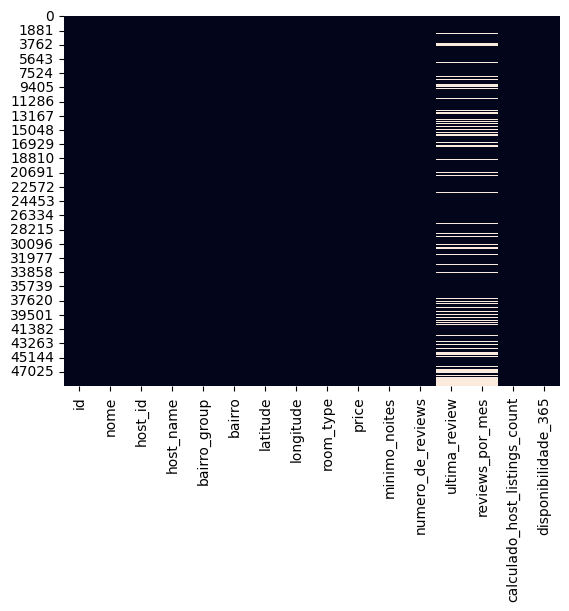

In [10]:
# Display null values with a heatmap figure

sns.heatmap(df.isnull(), cbar=False)

### Primeiras impressões do dataset

  * São aproximadamente 50 mil linhas de dados em 16 colunas;

  * Os tipos de dados já estão adequados, ou seja, os dados do tipo texto estão como object e os dados do tipo numérico estão como int64 ou float64. Há apenas a coluna ultima_review que possui um dado de data que esta tipada como object, será necessário alterar esta tipagem;

  * São poucos dados nulos, host_nome e nome. Existem muitos dados ausentes de reviews_por_mes e ultimas_reviews (aprox. 20%), pois são informações que dependem dos inquilinos / hóspedes e muitos não fazem este tipo de observação;

  * Para utilizar os modelos de Machine Learning, será necessário converter colunas categóricas para features numéricas. Irei realizar esta etapa em paralelo à análise exploratória e manter as duas informações até chegar na etapa de modelagem. Desta forma será possível escolher qual tipo de informação é melhor para aparecer em cada momento.

### Dicionário das variáveis

  * id => Atua como uma chave exclusiva para cada anúncio nos dados do aplicativo

  * nome => Representa o nome do anúncio

  * host_id => Representa o id do usuário que hospedou o anúncio

  * host_name => Contém o nome do usuário que hospedou o anúncio

  * bairro_group => Contém o nome do bairro onde o anúncio está localizado

  * bairro => Contém o nome da área onde o anúncio está localizado

  * latitude => Contém a latitude do local

  * longitude => Contém a longitude do local

  * room_type => Contém o tipo de espaço de cada anúncio

  * price => Contém o preço por noite em dólares listado pelo anfitrião

  * minimo_noites => Contém o número mínimo de noites que o usuário deve reservar
  
  * numero_de_reviews => Contém o número de comentários dados a cada listagem

  * ultima_review => Contém a data da última revisão dada à listagem

  * reviews_por_mes => Contém o número de avaliações fornecidas por mês

  * calculado_host_listings_count => Contém a quantidade de listagem por host

  * disponibilidade_365 => Contém o número de dias em que o anúncio está disponível para reserva


# Feature Engineering

In [11]:
# Creating a new feature with the distance from central park
# It can be useful to evaluate price ranges, the ideia is that locations near central manhattan must be expensive than others

central_park =  (40.785091, -73.968285) # (lat, long) don't confuse

# Using a lambda function with apply to populate new column

df['dist_central_park'] = df.apply(lambda x: round(geopy.distance.geodesic(central_park, (x['latitude'], x['longitude'])).km, 2), axis= 1)


In [12]:
# Changing categories to numbers in bairro_group feature

df.bairro_group.unique()


array(['Manhattan', 'Brooklyn', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [13]:
# Convert bairro_group to numerical
# This feature has few categories and can be converted using a lambda function with apply

df['bairro_group_num'] = df['bairro_group'].apply(lambda x: 1 if x == 'Manhattan'
                                                       else 2 if x == 'Brooklyn'
                                                       else 3 if x == 'Queens'
                                                       else 4 if x == 'Staten Island' else 5)


In [14]:
# Change data type

df['bairro_group_num'] = df['bairro_group_num'].astype('int')


In [15]:
# Changing categories to numbers in room_type feature

df.room_type.unique()


array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

In [16]:
# Convert room_type to numerical
# This feature has few categories and can be converted using a lambda function with apply

df['room_type_num'] = df['room_type'].apply(lambda x: 1 if x == 'Entire home/apt' else 2 if x == 'Private room' else 3)

# Change data type

df['room_type_num'] = df['room_type_num'].astype('int')


In [17]:
# Change data type of dates to datetime

df['ultima_review'] = pd.to_datetime(df['ultima_review'], errors= 'coerce')


In [18]:
# Changing categories to numbers in bairro feature

# In this case there are many different categories so it's best if we use the One Hot Encoding algorithm
df.bairro.nunique()


221

In [19]:
bairros_50 = df['bairro'].value_counts().sort_values(ascending=False).head(50)
bairros_50

# As there are many neighboorhods that contains only one data entry, we can select some of the most important
# This way we can have a dataset that captures the feature importance but without needing to create lots of new columns
# Lets say the 50 most important neighborhoods


Williamsburg                 3920
Bedford-Stuyvesant           3714
Harlem                       2658
Bushwick                     2465
Upper West Side              1971
Hell's Kitchen               1958
East Village                 1853
Upper East Side              1798
Crown Heights                1564
Midtown                      1545
East Harlem                  1117
Greenpoint                   1115
Chelsea                      1113
Lower East Side               911
Astoria                       900
Washington Heights            899
West Village                  768
Financial District            744
Flatbush                      621
Clinton Hill                  572
Long Island City              537
Prospect-Lefferts Gardens     535
Park Slope                    506
East Flatbush                 500
Fort Greene                   489
Murray Hill                   485
Kips Bay                      470
Flushing                      426
Ridgewood                     423
Greenwich Vill

In [20]:
# Using aplly with a lambda function to minimize neighborhood categories

df['bairro'] = df['bairro'].apply(lambda x: x if x in bairros_50 else 'outros')

In [21]:
# Using pd.dummies to encode 'bairro' column

df_one_hot = pd.get_dummies(df, columns=['bairro'])

display(df_one_hot.head(10))

id                                              nome  host_id  \
0  2595                             Skylit Midtown Castle     2845   
1  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
2  3831                   Cozy Entire Floor of Brownstone     4869   
3  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
4  5099         Large Cozy 1 BR Apartment In Midtown East     7322   
5  5121                                   BlissArtsSpace!     7356   
6  5178                  Large Furnished Room Near B'way      8967   
7  5203                Cozy Clean Guest Room - Family Apt     7490   
8  5238                Cute & Cozy Lower East Side 1 bdrm     7549   
9  5295                  Beautiful 1br on Upper West Side     7702   

     host_name bairro_group  latitude  longitude        room_type  price  \
0     Jennifer    Manhattan  40.75362  -73.98377  Entire home/apt    225   
1    Elisabeth    Manhattan  40.80902  -73.94190     Private room    150   
2  LisaRoxanne     Brooklyn  40.68514  -73.95976  Entire home/apt     89   
3        Laura    Manhattan  40.79851  -73.94399  Entire home/apt     80   
4        Chris    Manhattan  40.74767  -73.97500  Entire home/apt    200   
5        Garon     Brooklyn  40.68688  -73.95596     Private room     60   
6     Shunichi    Manhattan  40.76489  -73.98493     Private room     79   
7    MaryEllen    Manhattan  40.80178  -73.96723     Private room     79   
8          Ben    Manhattan  40.71344  -73.99037  Entire home/apt    150   
9         Lena    Manhattan  40.80316  -73.96545  Entire home/apt    135   

   minimo_noites  ...  bairro_Sunnyside bairro_Sunset Park  \
0              1  ...                 0                  0   
1              3  ...                 0                  0   
2              1  ...                 0                  0   
3             10  ...                 0                  0   
4              3  ...                 0                  0   
5             45  ...                 0                  0   
6              2  ...                 0                  0   
7              2  ...                 0                  0   
8              1  ...                 0                  0   
9              5  ...                 0                  0   

   bairro_Theater District  bairro_Upper East Side  bairro_Upper West Side  \
0                        0                       0                       0   
1                        0                       0                       0   
2                        0                       0                       0   
3                        0                       0                       0   
4                        0                       0                       0   
5                        0                       0                       0   
6                        0                       0                       0   
7                        0                       0                       1   
8                        0                       0                       0   
9                        0                       0                       1   

   bairro_Washington Heights  bairro_West Village  bairro_Williamsburg  \
0                          0                    0                    0   
1                          0                    0                    0   
2                          0                    0                    0   
3                          0                    0                    0   
4                          0                    0                    0   
5                          0                    0                    0   
6                          0                    0                    0   
7                          0                    0                    0   
8                          0                    0                    0   
9                          0                    0                    0   

   bairro_Woodside  bairro_outros  
0   

# Análise Exploratória

In [22]:
# Applying a plot style to the charts

#plt.style.use('seaborn-v0_8')

sns.set_style('darkgrid', {'grid.color': '.8',
                           'grid.linestyle': '-',
                           'text.color': '.2',
                           'xtick.color': 'dimgray',
                           'ytick.color': 'dimgray',
                           'axes.labelcolor': 'dimgray'})

# Defining a color pallete

colors = ['#4c94de', 'grey', 'cornflowerblue', 'silver', 'lightsteelblue', 'whitesmoke']
sns.set_palette(sns.color_palette(colors))


In [23]:
# First of all, we can look at a map with geographical distribution
# Using plotly express

data_map = df[['id', 'latitude', 'longitude', 'price', 'room_type']]

mapa = px.scatter_mapbox(data_map, lat='latitude', lon= 'longitude',
                  hover_name= 'id',
                  hover_data= 'price',
                  color= 'room_type',
                  size= 'price',
                  color_continuous_scale= px.colors.cyclical.IceFire,
                  zoom=10,
                  height=300)

mapa.update_layout(mapbox_style= 'open-street-map')
mapa.update_layout(height= 680, margin={'r':0, 't':0, 'l':0, 'b':0})
mapa.show()


###Mapeando Regiões mais Valorizadas

In [143]:
# Analysing mean values of each bairro_groups

bairros_group_mean = df.groupby(by= 'bairro_group')['price'].mean()

In [145]:
bairros_group_mean.sort_values(ascending= False)

bairro_group
Manhattan        196.875814
Brooklyn         124.381983
Staten Island    114.812332
Queens            99.517649
Bronx             87.496792
Name: price, dtype: float64

In [146]:
# Analysing how many properties are listed on each bairro_groups

imoveis_bairro_group = df.groupby(by= 'bairro_group')['id'].count()

In [147]:
imoveis_bairro_group.sort_values(ascending= False)

bairro_group
Manhattan        21661
Brooklyn         20103
Queens            5666
Bronx             1091
Staten Island      373
Name: id, dtype: int64

#### Qual seria a melhor região para investir em imóveis?

  * A análise das médias de preço por região da cidade, aliadas à análise do estoque de imóveis por região não é suficiente para concluirmos qual seria a melhor região da cidade para investir.

  * Seria necessário incluir ao menos a informação de quais são as regiões que mais alugam imóveis na cidade.

  * Certamente investimentos nas partes mais valorizadas da cidade (manhattan em geral) são mais dispendiosos por terem um metro quadrado de construção mais caro, porém podem ser mais rentáveis a médio e longo prazo devido à valorização dos imóveis e à facilidade de alugar.

### Observações sobre o mapa

Este mapa mostra a distribuição geográfica dos imóveis na região de New York, relacionando localização, o tipo de imóvel e o preço cobrado. Quanto maior o tamanho do ponto, maior o preço.

  * A maioria dos imóveis estão localizados na ilha de Manhattan, seguido por uma grande quantidade nos bairros do Brooklyn e Williansburg e uma quantidade menor na região do Bronx. Há também alguns poucos imóveis em outras regiões adjacentes e mais afastadas do centro.

  * A distribuição geográfica dos imóveis reflete a predileção dos turistas ou inquilinos temporários por regiões mais centrais e próximas ao centro de Manhattan.

  * Também podemos ver que predominam os imóveis do tipo "Entire Home / Apartment", seguido pelo tipo "Entire Room". São poucos os imóveis na categoria "Shared Room".

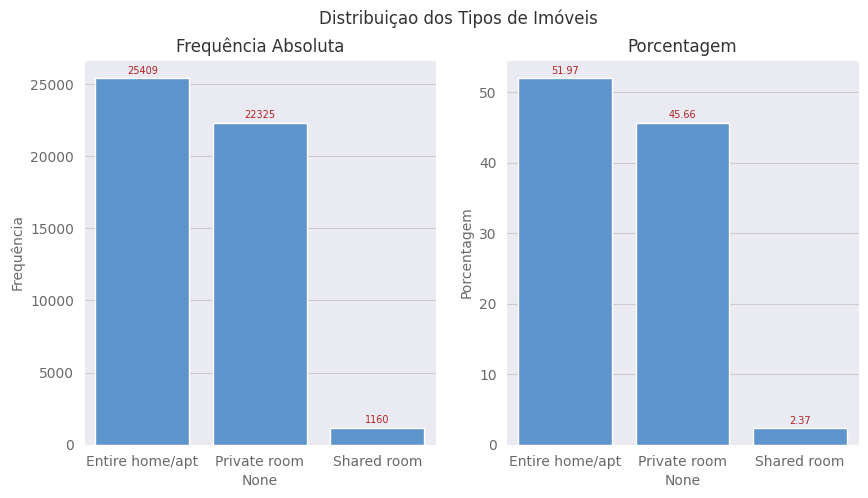

room_type        Frequência  Porcentagem
Entire home/apt       25409        51.97
Private room          22325        45.66
Shared room            1160         2.37

In [24]:
# Looking for distributions on categorical attributes
# Ploting distributions and percentage of room_type

dist_abs = df['room_type'].value_counts()
dist_percent = round(df['room_type'].value_counts(normalize= True) * 100, 2)

freq = pd.DataFrame({'Frequência':dist_abs, 'Porcentagem': dist_percent})
freq.rename_axis('room_type', axis='columns', inplace= True)

fig, axes = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Distribuiçao dos Tipos de Imóveis')
axes[0].set_title('Frequência Absoluta')
axes[1].set_title('Porcentagem')

sns.barplot(x= freq.index, y= freq['Frequência'], ax=axes[0])
sns.barplot(x= freq.index, y= freq['Porcentagem'], ax=axes[1])

for ax in axes:
  ax.bar_label(ax.containers[0], fontsize= 7, color='firebrick', padding= 2)

plt.show()
display(freq)

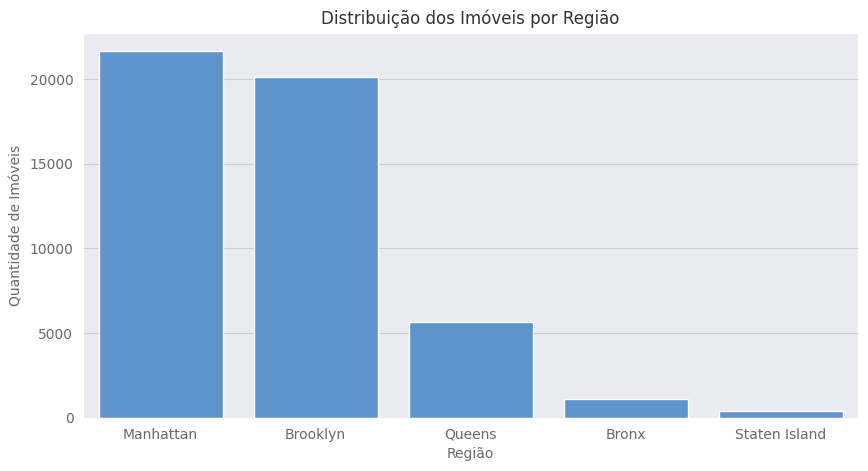

In [25]:
# Analysing main city areas

neighborhoods_groups = df.groupby('bairro_group').size().reset_index(name= 'quantidade')
pd.DataFrame(neighborhoods_groups).sort_values(by= ['quantidade'], ascending= False)

# Plot distribution chart

neighborhoods_groups_top5 = neighborhoods_groups.sort_values(by= 'quantidade', ascending= False).head(5)

plt.figure(figsize=(10, 5))
sns.barplot(x= neighborhoods_groups_top5['bairro_group'], y= neighborhoods_groups_top5['quantidade'])
plt.xlabel('Região')
plt.ylabel('Quantidade de Imóveis')
plt.title('Distribuição dos Imóveis por Região')
plt.xticks(rotation=0)

plt.show()

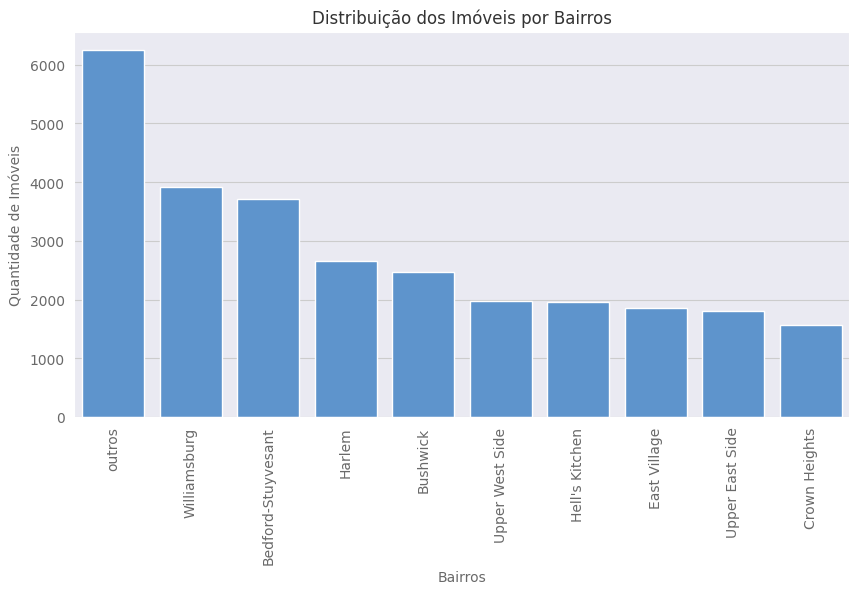

In [26]:
# Analysing main neighborhoods

neighborhoods = df.groupby('bairro').size().reset_index(name= 'quantidade')
pd.DataFrame(neighborhoods).sort_values(by= ['quantidade'], ascending= False)

# Plot distribution chart

neighborhoods_top10 = neighborhoods.sort_values(by= 'quantidade', ascending= False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x= neighborhoods_top10['bairro'], y= neighborhoods_top10['quantidade'])
plt.xlabel('Bairros')
plt.ylabel('Quantidade de Imóveis')
plt.title('Distribuição dos Imóveis por Bairros')
plt.xticks(rotation=90)

plt.show()


  * Os gráficos acima confirmam as observações sobre o mapa:

  1 - O tipo de imóvel mais frequente é o tipo "entire_room";

  2 - As regiões mais abundantes em ofertas são Manhattan e Brooklyn;

  3 - O bairro com maior quantidade de ofertas é Williamsburg;

### Distribuição dos Preços

  * A grande maioria dos preços está entre 50 e 100 , seguido pela faixa de 100 a 150 dólares;

  * 50% dos preços estão na faixa até 106 dólares (mediana);

  * 75% dos preços estão na faixa até 175 dólares;

  * A menor parte dos preços está acima dos 175 dólares, porém estes valores mais altos, que variam até 10.000, puxam a média de preços para cima, ficando a média em 152 dólares.


<Axes: xlabel='price', ylabel='Count'>

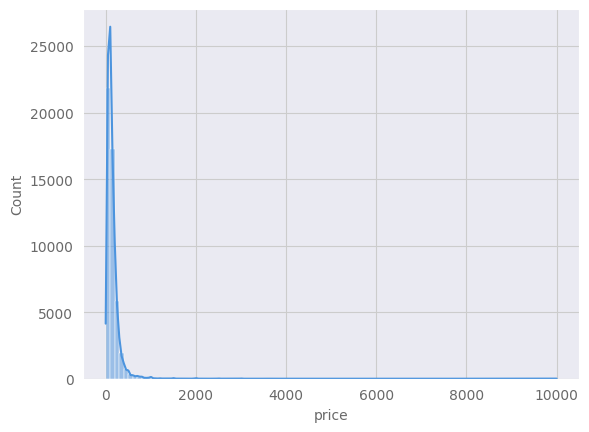

In [27]:
# Plot a raw histogram to start the analysis, we can see that the distribution is highly skewed

sns.histplot(data= df, x= 'price', bins= 10, binrange= (0,1000), kde= True)

In [28]:
# Binning values to better understand distribution, using pd.cut

bins= (0, 50, 100, 150, 200, 250, 300, 400, 500, 1000, 10000)

price_bins= pd.cut(df.price, bins= bins, right= True)

bin_count= price_bins.value_counts()

display(bin_count)

(50, 100]        17367
(100, 150]       10028
(150, 200]        6554
(0, 50]           6550
(200, 250]        3176
(250, 300]        1851
(300, 400]        1594
(500, 1000]        805
(400, 500]         719
(1000, 10000]      239
Name: price, dtype: int64

In [29]:
# Analysing price distribution

df['price'].describe()

# Price ranges until $10000, mean is $152, median is $106


count    48894.000000
mean       152.720763
std        240.156625
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

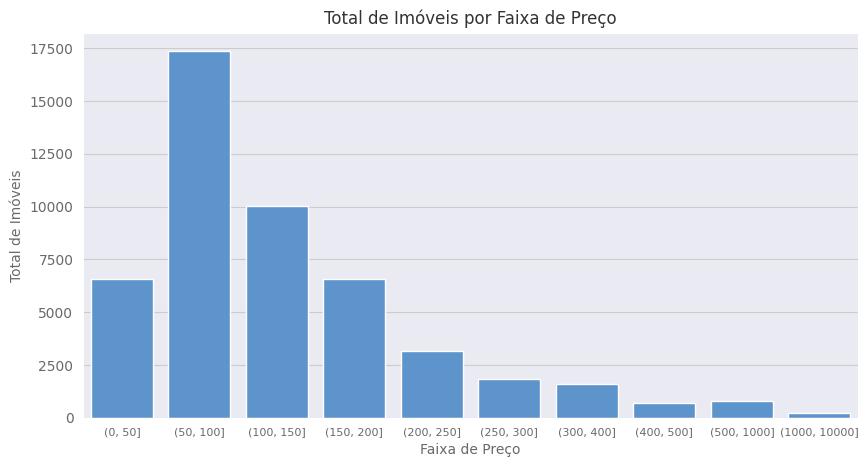

In [30]:
# Plot the chart

df['price_bins']= pd.cut(df.price, bins= bins, right= True)

plt.figure(figsize=(10, 5))
sns.countplot(x= 'price_bins', data= df)
plt.title('Total de Imóveis por Faixa de Preço')
plt.xlabel('Faixa de Preço')
plt.ylabel('Total de Imóveis')
plt.xticks(fontsize= 8)
plt.show()

### Distribuição dos imóveis com mínimo de noites e disponibilidade

In [31]:
# Describe the basic statistical information

df['minimo_noites'].describe()

# There are some outliers in the data, but we can clearly see that 75% of the data entries is above 5 days

count    48894.000000
mean         7.030085
std         20.510741
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimo_noites, dtype: float64

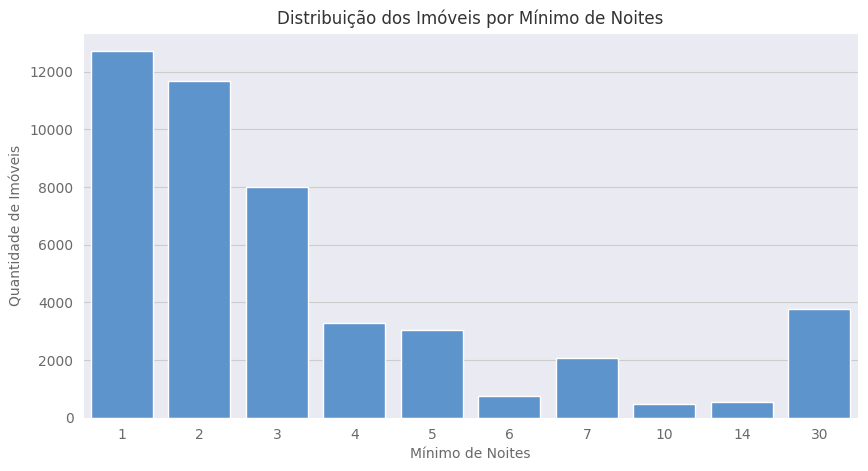

In [32]:
# Plot distribution chart of minimum stay

minimum_nights = df.groupby('minimo_noites').size().reset_index(name= 'quantidade')
minimum_nights_top10 = pd.DataFrame(minimum_nights).sort_values(by= ['quantidade'], ascending= False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x= 'minimo_noites', y= 'quantidade', data= minimum_nights_top10)
plt.xlabel('Mínimo de Noites')
plt.ylabel('Quantidade de Imóveis')
plt.title('Distribuição dos Imóveis por Mínimo de Noites')
plt.xticks(rotation=0)

plt.show()

In [33]:
# Describe the basic statistical information

df['disponibilidade_365'].describe()

count    48894.000000
mean       112.776169
std        131.618692
min          0.000000
25%          0.000000
50%         45.000000
75%        227.000000
max        365.000000
Name: disponibilidade_365, dtype: float64

0      17533
365     1294
364      491
1        408
89       361
       ...  
195       26
183       24
196       24
181       23
202       20
Name: disponibilidade_365, Length: 366, dtype: int64

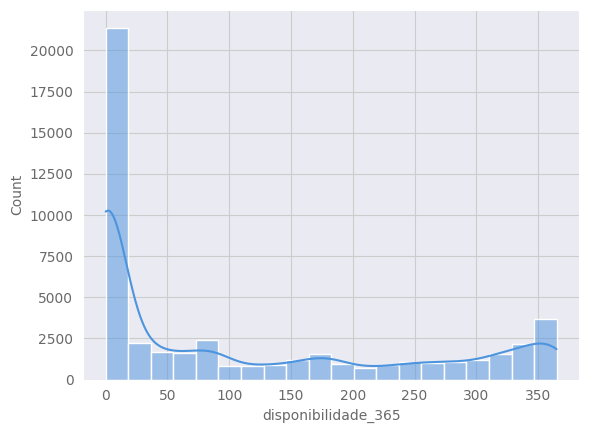

In [34]:
# Plot a raw histogram to start the analysis, we can see that the distribution is highly skewed

sns.histplot(data= df, x= 'disponibilidade_365', bins= 20, kde= True)

display(df['disponibilidade_365'].value_counts())

# we can see that are many entries with zero day availability, it appears to be an error or just profiles that are still in completion


### O que pode significar a quantidade ou ausência de reviews?

In [35]:
df['numero_de_reviews'].describe()

count    48894.000000
mean        23.274758
std         44.550991
min          0.000000
25%          1.000000
50%          5.000000
75%         24.000000
max        629.000000
Name: numero_de_reviews, dtype: float64

In [36]:
df['numero_de_reviews'].value_counts()

0      10052
1       5244
2       3465
3       2520
4       1994
       ...  
313        1
540        1
480        1
326        1
341        1
Name: numero_de_reviews, Length: 394, dtype: int64

<Axes: xlabel='numero_de_reviews', ylabel='Count'>

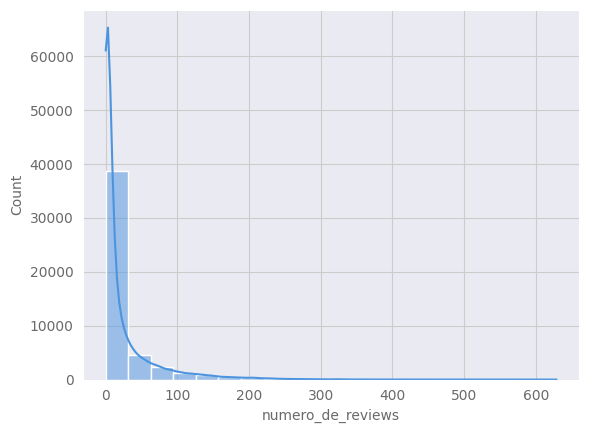

In [37]:
sns.histplot(data= df, x= 'numero_de_reviews', bins= 20, kde= True)

In [38]:
df['reviews_por_mes'].describe()

count    38842.000000
mean         1.373251
std          1.680453
min          0.010000
25%          0.190000
50%          0.720000
75%          2.020000
max         58.500000
Name: reviews_por_mes, dtype: float64

In [39]:
df['reviews_por_mes'].value_counts()

0.02     919
1.00     893
0.05     893
0.03     804
0.16     667
        ... 
9.53       1
9.74       1
6.06       1
8.25       1
10.54      1
Name: reviews_por_mes, Length: 937, dtype: int64

<Axes: xlabel='reviews_por_mes', ylabel='Count'>

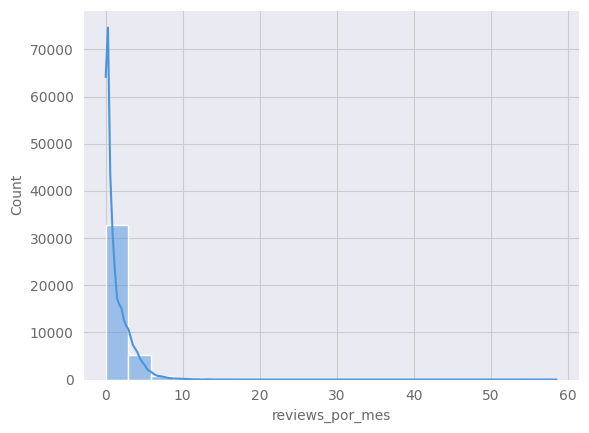

In [40]:
sns.histplot(data= df, x= 'reviews_por_mes', bins= 20, kde= True)

###Análise de padrões no texto do nome do local

  * Usando NLTK (Natural Language Toolkit) para "ler" e analisar os textos dos nomes dos imóveis;

  * Posteriormente poderemos relacionar estes padrões ou palavras para entendermos se há relação entre preços e títulos dos locais.
  

In [41]:
# Using NLTK to identify patterns in text

stopwords_list = stopwords.words('english')


In [42]:
# Define a function to remove punctuation and other signals and put all texts in lower case


def normalizaTexto(texto):
   if not isinstance(texto, str):
    return ""
   else:
    re.sub(r'[-.;:?!"())\']', '', texto)
    normalize('NFKD', texto).encode('ASCII', 'ignore').decode('ASCII')


In [43]:
# Listing all titles

all_titles = []

for title in df['nome'].astype(str):
  normalizaTexto(title)
  title.lower()
  all_titles.append(title)

In [44]:
# Tokenizing the titles for further removing stop words

all_tokens = []

for t in all_titles:
  tokens = t.split()
  all_tokens.append(tokens)


In [45]:
# Removing STOP WORDS from tokens

novo_titles = []

for token in all_tokens:
  if token not in stopwords_list:
    text_join = ' '.join(token)
    novo_titles.append(text_join)


In [47]:
# Create a dataset from novo_titles

df_nomes = pd.DataFrame(novo_titles, columns= ['titulo_original'])


In [48]:
nlp = spacy.load('en_core_web_sm')

In [49]:
# Function to find entities

def findEnt(text):
  doc = nlp(text)
  return list(doc.ents)


In [50]:
df_nomes['entidades'] = df_nomes['titulo_original'].apply(lambda x: findEnt(x))

In [52]:
df_nomes['price'] = df['price']

In [63]:
df_nomes.loc[(df_nomes['price'] < 10000) &  (df_nomes['price'] > 3000)].sort_values(by= 'price', ascending= False)

titulo_original  \
6529                                  Spanish Harlem Apt   
40432  2br - The Heart of NYC: Manhattans Lower East ...   
12341                Quiet, Clean, Lit @ LES & Chinatown   
30267  Beautiful/Spacious 1 bed luxury flat-TriBeCa/Soho   
4376                                       Film Location   
29661          East 72nd Townhouse by (Hidden by Airbnb)   
45665                               Gem of east Flatbush   
42522                70' Luxury MotorYacht on the Hudson   
44033                   3000 sq ft daylight photo studio   
37193                 Apartment New York Hell’s Kitchens   
48042       Luxury TriBeCa Apartment at an amazing price   
3773                    SUPER BOWL Brooklyn Duplex Apt!!   
29663          Park Avenue Mansion by (Hidden by Airbnb)   
15559                 Luxury townhouse Greenwich Village   
3536                  UWS 1BR w/backyard + block from CP   
3719                 SuperBowl Penthouse Loft 3,000 sqft   
43008    Midtown Manhattan great location (Gramacy park)   
37999      4-Floor Unique Event Space 50P Cap. - #10299B   
22352                            Victorian Film location   
25824                                           Fulton 2   
26738                                         Broadway 1   
2697                  Beautiful 1 Bedroom in Nolita/Soho   
4344                    NearWilliamsburg bridge 11211 BK   
4375                                Photography Location   
46613                     Northside Williamsburg Stunner   
43669   Beautiful private Brooklyn room with kitchenette   
45866        bay ridge & sunset park furnished apartment   
28946   Chelsea Gallery for events, exhibitions, fashion   
42735  30 days minimum Time square West Midtown apart...   
3694                  NYC SuperBowl Wk 5 Bdrs River View   
1861                    Sunny, Family-Friendly 2 Bedroom   
21820  The Otheroom Bar/Event/Filming Space -read det...   
25900    Greenwich Village Townhome with Private Garden!   
17664        VIP Duplex Townhouse with Private Garden!!!   
34850             A Night at Anchor Aboard Yacht Ventura   
3787                   Prime NYC Location for Super Bowl   
42541             West 84th Street by (Hidden by Airbnb)   
37863                   NYC HOLIDAY!!!! April 15- May 15   
29662          East 7th Street III by (Hidden by Airbnb)   
41215             West 88th Street by (Hidden by Airbnb)   
28945   Chelsea Gallery Space for events and exhibitions   
39242     Furnished 1000sq large 2bed + office in Harlem   

                                               entidades  price  
6529                                         [(Spanish)]   9999  
40432           [(NYC), (Manhattans, Lower, East, Side)]   9999  
12341                      [(Lit, @, LES, &, Chinatown)]   9999  
30267                                              [(1)]   8500  
4376                                                  []   8000  
29661                                                 []   7703  
45665                                       [(Flatbush)]   7500  
42522             [(70), (Luxury, MotorYacht), (Hudson)]   7500  
44033                         [(3000, sq, ft, daylight)]   6800  
37193                            [(New, York, Hell, ’s)]   6500  
48042                                                 []   6500  
3773              [(SUPER, BOWL, Brooklyn, Duplex, Apt)]   6500  
29663                          [(Park, Avenue, Mansion)]   6419  
15559                             [(Greenwich, Village)]   6000  
3536                                       [(1BR), (CP)]   6000  
3719                   [(SuperBowl, Penthouse), (3,000)]   5250  
43008                           [(Manhattan), (Gramacy)]   5100  
37999  [(4, -, Floor, Unique, Event), (50P, Cap), (10...   5000  
22352                                [(Victorian, Film)]   5000  
25824                                    [(Fulton), (2)]   5000  
26738                                    [(Broadway, 1)]   5000  
2697    

####Relação entre os textos dos títulos e o valor dos anúncios

  * Não foi possível identificar um padrão claro entre o texto que é usaado nos títulos e o valor do aluguel do imóvel. Obviamente algumas palavras se repetem mais frequentemente entre os imóveis mais caros, por exemplo 'luxury', 'beautiful', 'spacious', 'penthouse', porém são palavras que descrevem características inerentes aos imóveis de alto padrão.

  * É mais coerente afirmar que os valores dos imóveis possuem maior relação com a localização em que estão, por exemplo 'Manhattan', 'Tribeca', 'Park Avenue', 'lower east side', que são regiões tradicionalmente mais conhecidas e mais caras da cidade, do que com adjetivos que são inseridos nos anúncios.

  * De todo modo, caberia aqui um estudo mais aprofundado sobre possíveis adjetivos colocados nos anúncios que chamam mais atenção dos clientes, mas para isso seria importante ter a informação de quais imóveis alugaram mais vezes e por mais tempo.

#Análise Multivariada

### Decompondo a variável Preço

  * O objetivo é avaliar de que forma a variável preço está relacionada a cda uma das ouitras variáveis importantes para comprender o problema;

  * Como a variável 'price' possui um amplo espectro de variação, para compreender e visualizar graficamente melhor as relações, em alguns momentos irei limitar o valor máximo a U$1000;

  * A relação entre preço e localização é a mais evidente e forte: Bairros da região de Manhattan possuem preços mais elevados, bairros de regiões mais distantes possuem valores mais baixos;

  * A variável distância até o Central Park tb influi no preço, como podemos ver no gráfico de dispersão abaixo, valores mais elevados só são alcançados em locais mais próximos ao centro de Manhattan. Há uma grande concentração de valores até 1000U$ dispersos por todas as distâncias, o que mostra que esta relação é mais válida entre imóveis de alto preço;
  
  * A segunda relação mais evdente que influencia no preço cobrado é o tipo do imóvel. Obviamente o tipo "Entire House or Apartment" possui os valores médios mais elevados, enquanto os imóveis do tipo "Shared Room" possuem valores médios mais baixos;

  * O número de reviews influencia no preço? Aparentemente o que ocorre é o oposto, o preço influencia na quantidade de reviews, uma vez que quanto mais caro o aluguel, menos vezes o imóvel aluga e portanto menos reviews ele terá;

  * O número mínimo de noites influi no preço? Não há evidência gráfica de que o número mínimo de noites influencie no preço, há imóveis com diferentes preços homogeneamente distribuídos em diferentes mínimos de noite;

  * A disponibilidade do imóvel possui relação com o preço? Também não se observa evidência gráfica de uma influência da disponibilidade no preço, há preços homogeneamente distribuídos ao longo de várias disponibilidades diferentes;


In [ ]:
# Creating a sample dataset with maximum price of U$ 1000

df_boxplot = df.loc[df['price'] < 1000]


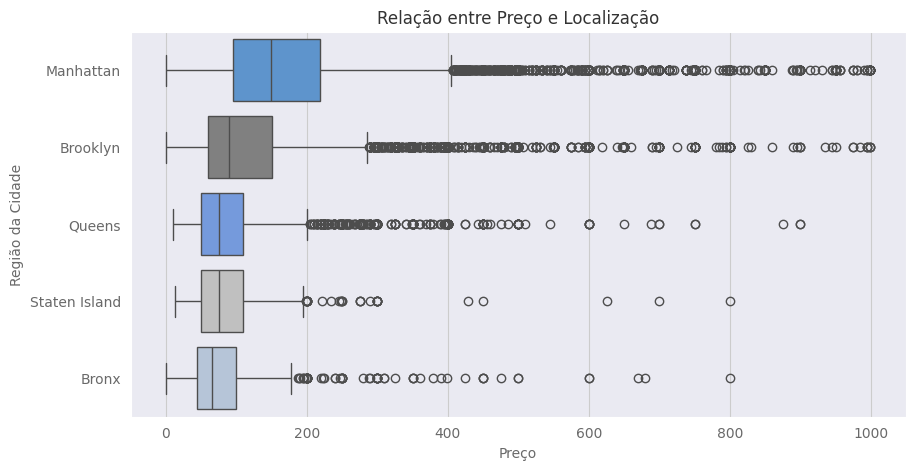

In [ ]:
# Analysis of boxplot between price and neighborhood

plt.figure(figsize=(10, 5))
sns.boxplot(y= 'bairro_group', x= 'price', data= df_boxplot, palette= colors)
plt.ylabel('Região da Cidade')
plt.xlabel('Preço')
plt.title('Relação entre Preço e Localização')
plt.xticks(rotation=0)

plt.show()

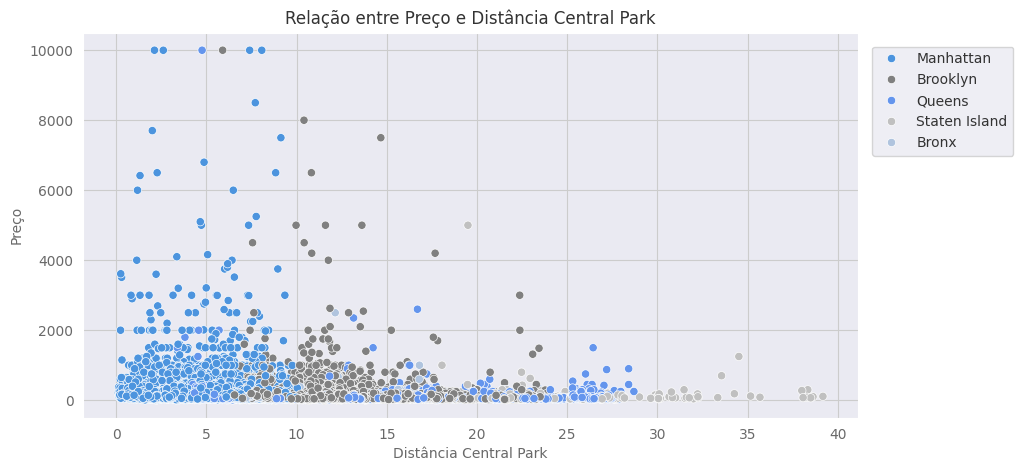

In [ ]:
# Analysis of scatterplot between price and dist_central_park

plt.figure(figsize=(10, 5))
sns.scatterplot(x= 'dist_central_park', y= 'price', hue= 'bairro_group', data= df)
plt.xlabel('Distância Central Park')
plt.ylabel('Preço')
plt.title('Relação entre Preço e Distância Central Park')
plt.xticks(rotation=0)

plt.legend(bbox_to_anchor= (1.0, 1.0), loc= 2, borderaxespad= 1)

plt.show()

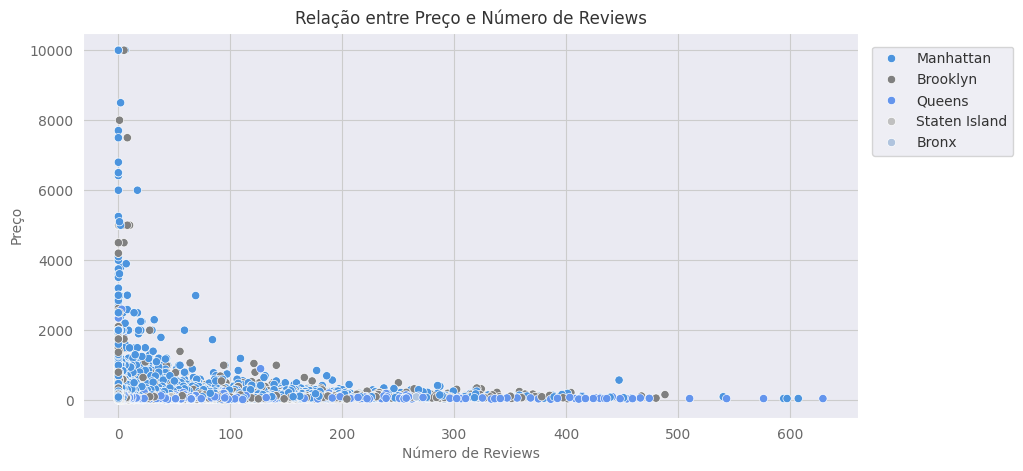

In [ ]:
# Analysis of scatterplot between price and reviews

plt.figure(figsize=(10, 5))
sns.scatterplot(x= 'numero_de_reviews', y= 'price', hue= 'bairro_group', data= df)
plt.xlabel('Número de Reviews')
plt.ylabel('Preço')
plt.title('Relação entre Preço e Número de Reviews')
plt.xticks(rotation=0)

plt.legend(bbox_to_anchor= (1.0, 1.0), loc= 2, borderaxespad= 1)

plt.show()

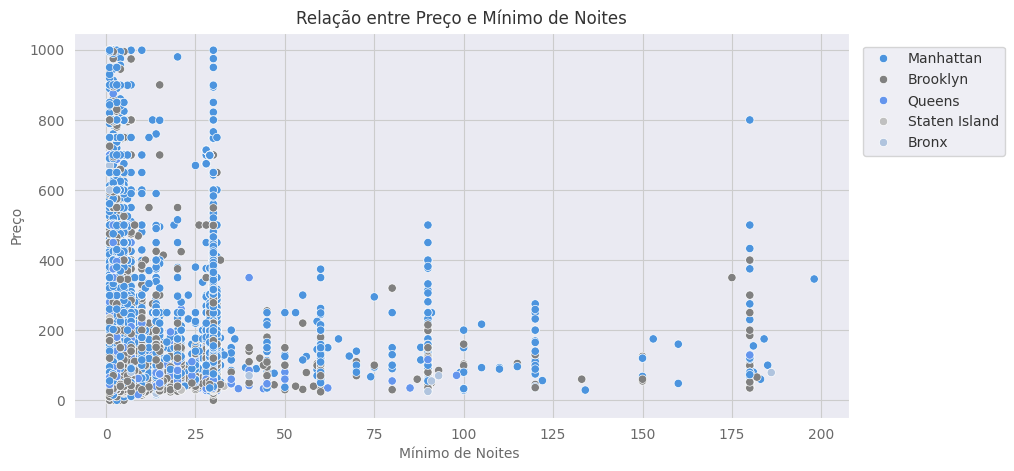

In [ ]:
# Analysis of scatterplot between price and minimum stay

# New dataset filtered with maximum 200 nights and maximum price of 1000

df_nights = df_boxplot.loc[df['minimo_noites'] < 200]

plt.figure(figsize=(10, 5))
sns.scatterplot(x= 'minimo_noites', y= 'price', hue= 'bairro_group', data= df_nights)
plt.xlabel('Mínimo de Noites ')
plt.ylabel('Preço')
plt.title('Relação entre Preço e Mínimo de Noites')
plt.xticks(rotation=0)

plt.legend(bbox_to_anchor= (1.0, 1.0), loc= 2, borderaxespad= 1)

plt.show()

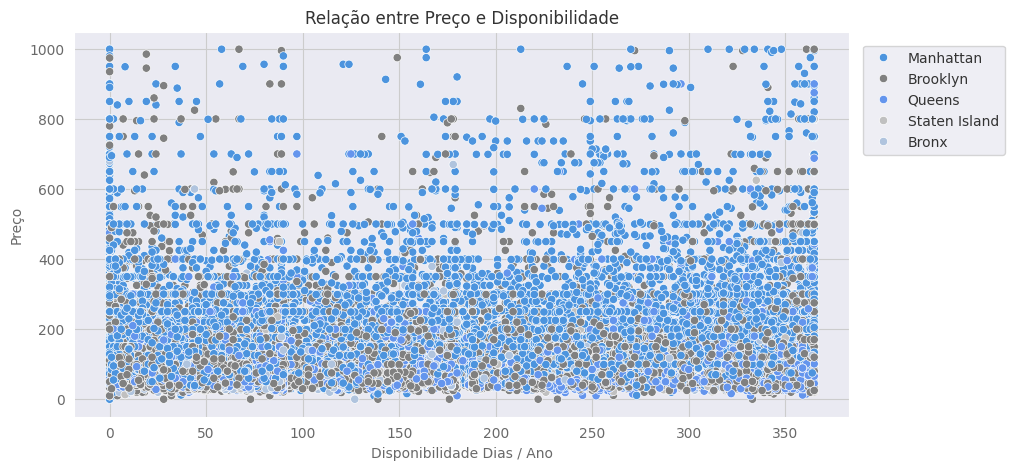

In [ ]:
# Analysis of scatterplot between price and availability

plt.figure(figsize=(10, 5))
sns.scatterplot(x= 'disponibilidade_365', y= 'price', hue= 'bairro_group', data= df_boxplot)
plt.xlabel('Disponibilidade Dias / Ano')
plt.ylabel('Preço')
plt.title('Relação entre Preço e Disponibilidade')
plt.xticks(rotation=0)

plt.legend(bbox_to_anchor= (1.0, 1.0), loc= 2, borderaxespad= 1)

plt.show()

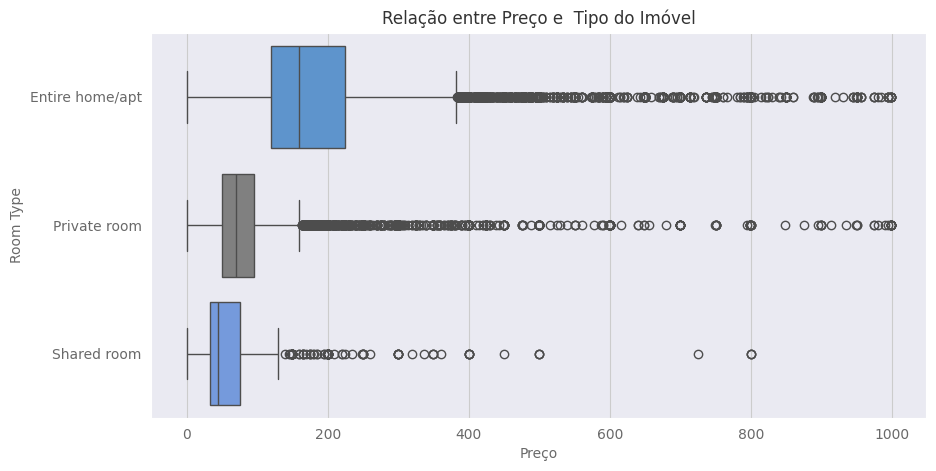

192.93280616705079

84.55230313369849

66.00173010380622

In [ ]:
# Analysis of boxplot between price and room type

plt.figure(figsize=(10, 5))
sns.boxplot(y= 'room_type', x= 'price', data= df_boxplot, palette= colors)
plt.ylabel('Room Type')
plt.xlabel('Preço')
plt.title('Relação entre Preço e  Tipo do Imóvel')
plt.xticks(rotation=0)

plt.show()

display(df_boxplot.loc[df_boxplot['room_type_num'] == 1]['price'].mean())
display(df_boxplot.loc[df_boxplot['room_type_num'] == 2]['price'].mean())
display(df_boxplot.loc[df_boxplot['room_type_num'] == 3]['price'].mean())

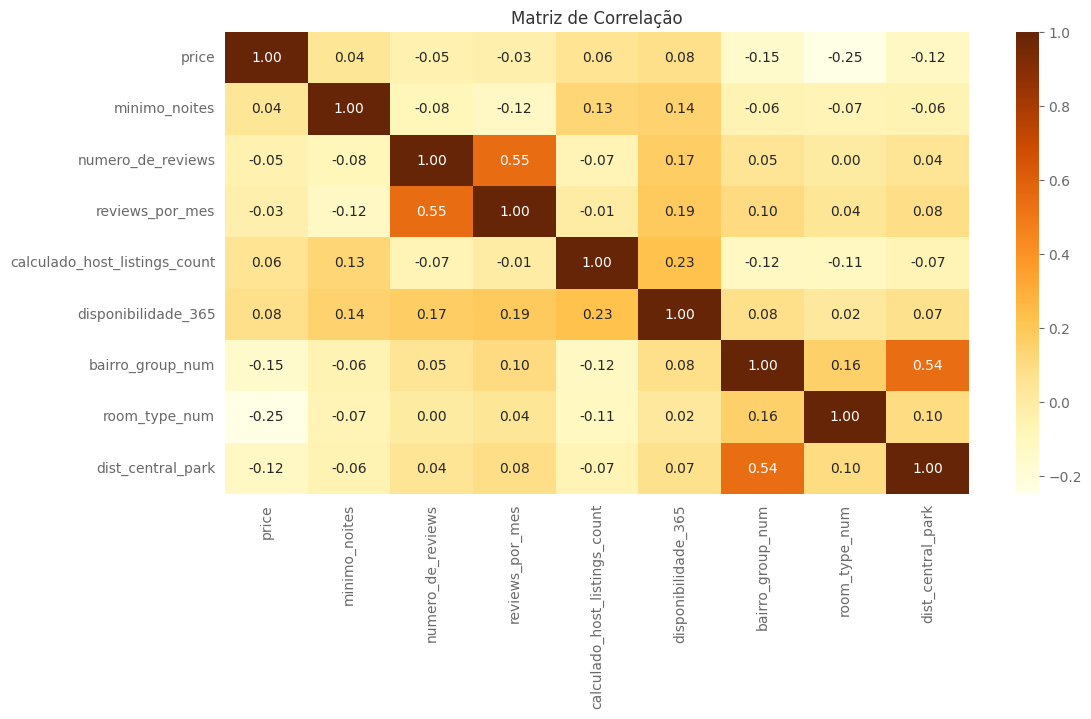

In [ ]:
# Ploting a correlation matrix

correlation = df[['bairro_group', 'bairro','price', 'minimo_noites', 'numero_de_reviews',
                  'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365',
                  'bairro_group_num', 'room_type_num', 'price_bins', 'dist_central_park']].corr()


plt.figure(figsize= (12, 6))
sns.heatmap(correlation, annot= True, cmap= 'YlOrBr', fmt= '.2f')
plt.title('Matriz de Correlação')
plt.show()

###Análise de Correlações

  * A matriz de correlações não apresenta nenhuma correlação forte, isso é importante para o modelo de machine learning, já que evita multicolinearidade.

  * As relações mais evidentes estão entre a variável alvo (price) e as variáveis 'room_type_num' e bairro_group_num' e também a variável 'dist_central_park';

  * Há uma relação mais forte entre as variáveis 'numero_de_reviews' e 'reviews_mes', isso parece um pouco óbvio, já que quanto mais reviews totais um imóvel possui, mais reviews por mês ele terá. Na hora de modelar podemos avaliar a necessidade de excluir ou não uma destas variáveis.

# Modelo Machine Learning

###Feature Pre Processing

  * Além dos encoders que já foram feitos nas variáveis categóricas, existem mais algumas etapas antes de aplicar os modelos:

  1 - Tratamento de valores faltantes, caso haja necessidade
  
  2 - Normalizações das distribuições

  3 - Divisão dos dados em Treino e Teste (train/test split)

  4 - Escalar os dados caso haja valores em grandezas muito diferentes

#### Tratamento de valores

In [ ]:
# Input values on reviews_por_mes

df['reviews_por_mes'].fillna(0, inplace= True)

In [ ]:
# Input values on ultima_review

df['ultima_review'].fillna(pd.Timestamp('2019-01-01'), inplace= True)

In [ ]:
df['price_bins'].unique()

[(200, 250], (100, 150], (50, 100], (150, 200], (250, 300], ..., (300.0, 400.0], (500.0, 1000.0], (400.0, 500.0], (1000.0, 10000.0], NaN]
Length: 11
Categories (10, interval[int64, right]): [(0, 50] < (50, 100] < (100, 150] < (150, 200] < ... <
                                          (300, 400] < (400, 500] < (500, 1000] < (1000, 10000]]

In [ ]:
# make a series to pass some value
cat_series= df['price_bins'].unique()

In [ ]:
# Input values on price_bins

df['price_bins'].fillna(cat_series[0], inplace= True)

In [ ]:
# Looking for missing values

# the features id, nome_id, host_id, host_name will not be used in the model

df.isnull().sum()

id                                0
nome                             16
host_id                           0
host_name                        21
bairro_group                      0
bairro                            0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimo_noites                     0
numero_de_reviews                 0
ultima_review                     0
reviews_por_mes                   0
calculado_host_listings_count     0
disponibilidade_365               0
dist_central_park                 0
bairro_group_num                  0
room_type_num                     0
price_bins                        0
dtype: int64

In [ ]:
# Merge the columns in df with df_one hot and generate a new dataset for the model

df_model = df.copy()


In [ ]:
df_one_hot.drop(columns= ['nome', 'host_id', 'host_name', 'bairro_group', 'latitude',
       'longitude', 'room_type', 'price', 'minimo_noites', 'numero_de_reviews',
       'ultima_review', 'reviews_por_mes', 'calculado_host_listings_count',
       'disponibilidade_365', 'dist_central_park', 'bairro_group_num',
       'room_type_num'], inplace= True)

In [ ]:
df_model= df_model.merge(df_one_hot, how= 'left', on= 'id')

In [ ]:
# Drop columns of df_model

df_model.drop(columns= ['nome', 'host_id', 'host_name', 'ultima_review', 'price_bins', 'bairro', 'bairro_group', 'room_type'], inplace= True)

In [ ]:
df_model.drop(columns= ['latitude', 'longitude'], inplace= True)

####Normalização das distribuições

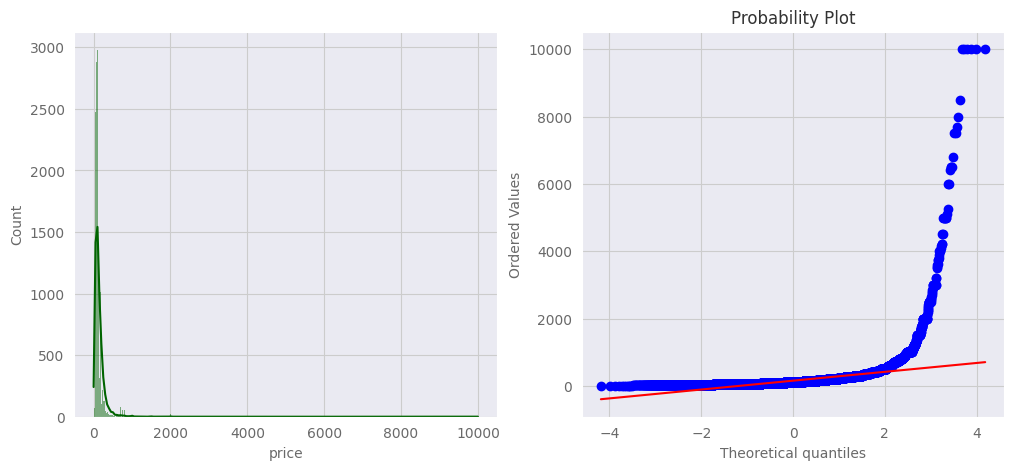

In [ ]:
# Testing normality of target variable

fig0 = plt.figure(figsize=(12, 5))
ax2 = plt.subplot(121)
fig0.add_subplot(ax2)

sns.histplot(df_model['price'], color='darkgreen', kde= True)

ax3 = plt.subplot(122)
fig0.add_subplot(ax3)
res = stats.probplot(df_model['price'], plot=ax3)
plt.show()


Através do gráfico de distribuição e do gráfico de quartis, podemos ver como a distribuição desta variável está enviesada

Após a transformação logarítmica, a distribuição da variável price ficou mais próxima de uma normal. Podemos testar a normalidade usando Kolmogorov - Sminorv, se P-value for maior que 0.05 então temos suficientes evidências para afirmar que a distribuição após a transformação ficou normalmente distribuída.

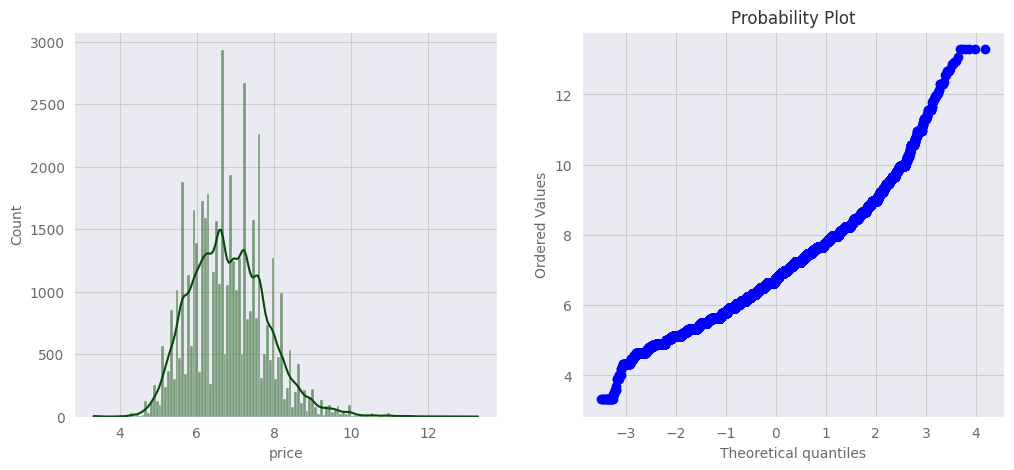

In [ ]:
# Histogram and normal probability plot after log transformation

transform_data = np.log2(df_model['price'])

fig0 = plt.figure(figsize=(12, 5))
ax2 = plt.subplot(121)
fig0.add_subplot(ax2)

sns.histplot(transform_data, color='xkcd:darkgreen', kde= True)

ax3 = plt.subplot(122)
fig0.add_subplot(ax3)
res = stats.probplot(transform_data, plot=ax3)
plt.show();

In [ ]:
# Kolmogorov - Smirnov test, if P value is greater than 0.05, then the data is normally distributed, whatever not...
# H0 > p -> Null hypothesis: the distribution is normally distributed
# Ha < p -> Alt hypothesis: the distribution is not normal

kstest(transform_data, 'norm')

# As p-value is less than 0.05, we have sufficient evidences to afirm that the distribution is normally distributed


KstestResult(statistic=0.999328034877231, pvalue=0.0, statistic_location=3.321928094887362, statistic_sign=-1)

In [ ]:
# As there are zero values, lets add 0.1 to each price. This way the log function will works correctly and it wiil be a little error

df_model['price'] = df_model['price'] + 0.1

df_model['price'] = np.log2(df_model['price'])

In [ ]:
df_model['price'].describe()

count    48894.000000
mean         6.818960
std          1.017712
min         -3.321928
25%          6.110614
50%          6.729281
75%          7.452035
max         13.287727
Name: price, dtype: float64

####Train Test Split

In [ ]:
# Now there is a dataset with the strictly necessary columns anda all numerical features
# Ready to split and train / test the models

#  Train test split

x = df_model.drop(columns= ['price'])
y = df_model['price']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size= 0.3, random_state= 71)


In [ ]:
# Show train test dataset shapes

display(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(34225, 60)

(34225,)

(14669, 60)

(14669,)

# Aplicando Modelos

In [ ]:
# Defining functions to apply models and evaluate results

# Define function to apply models
def model_apply (model, x_train, x_test, y_train):
  print('Aplicando o Modelo')
  model.fit(x_train, y_train)
  y_predict = model.predict(x_test)
  return y_predict

# Define a function to plot distplot
def distplot(y_test, y_predict):
  axl= sns.distplot(y_test, hist=False, color='r', label='Valor Real')
  sns.distplot(y_predict, hist=False, ax=axl, color='b', label='Valor Previsão')
  plt.legend()
  plt.show()

  if type(model) == DecisionTreeRegressor:
    plt.figure(figsize=(25, 12))
    plot_tree(model, filled= True)
    plt.show()
  else:
    pass

# Create a function to plot residual chart
def residplot(y_test, y_predict):
  sns.residplot(x= y_test, y= y_predict, color= 'r')
  plt.title('Resíduos')
  plt.ylabel('Erro')

# Define function to evaluate
def evaluate(y_test, y_predict):
  distplot(y_test, y_predict)
  residplot(y_test, y_predict)
  print('R2: ', r2_score(y_test, y_predict))
  print('MAE: ', mean_absolute_error(y_test, y_predict))
  print('MAPE: ', mean_absolute_percentage_error(y_test, y_predict))
  print('MSE: ', mean_squared_error(y_test, y_predict))
  print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_predict)))


# Define a function to plot feature importances
def feature_importance (model):
  feat_imp = pd.Series(model.feature_importances_, index= x_train.columns).sort_values(ascending=False)

  top_feat = feat_imp[:6]
  all_feat = feat_imp[::]

  fig, axes = plt.subplots(1,2, figsize=(12,8))
  top_feat.plot(kind='bar', ax=axes[0])
  all_feat.plot(kind='bar', ax=axes[1])
  axes[0].set_title(f"{model} - Top 6 Most Important Features")
  axes[1].set_title(f"{model} - All Feature Importances")

  return print('')

# Define a function to store each model results
def append_results (model, y_test, y_predict):
  model_name.append(model.__class__.__name__)
  R2.append(round(r2_score(y_test, y_predict), 3))
  MAE.append(round(mean_absolute_error(y_test, y_predict), 3))
  MAPE.append(round(mean_absolute_percentage_error(y_test, y_predict), 3)*100)
  MSE.append(round(mean_squared_error(y_test, y_predict), 3))
  RMSE.append(round(np.sqrt(mean_squared_error(y_test, y_predict)), 3))

  return print('Resultados adicionados')


In [ ]:
# Define a pipeline function putting all functions together

def pipeline(model, x_train, x_test, y_train, y_test):
  model_apply (model, x_train, x_test, y_train)
  y_predict = model.predict(x_test)
  evaluate(y_test, y_predict)
  feature_importance(model)
  append_results(model, y_test, y_predict)

  print(f"Score Treino: {model.score(x_train, y_train)}\n")
  print(f"Score Teste: {model.score(x_test, y_test)}\n")

  return print('Função completa aplicada \n')


In [ ]:
# Create empty lists to store the results

model_name = []
R2 = []
MAE = []
MAPE = []
MSE = []
RMSE = []



In [ ]:
# Define models

tree = DecisionTreeRegressor(max_depth= 5, random_state= 71)

rf_reg = RandomForestRegressor(random_state= 71)

xgboost= XGBRegressor(random_state= 71)

models = [tree, rf_reg, xgboost]

Aplicando o Modelo


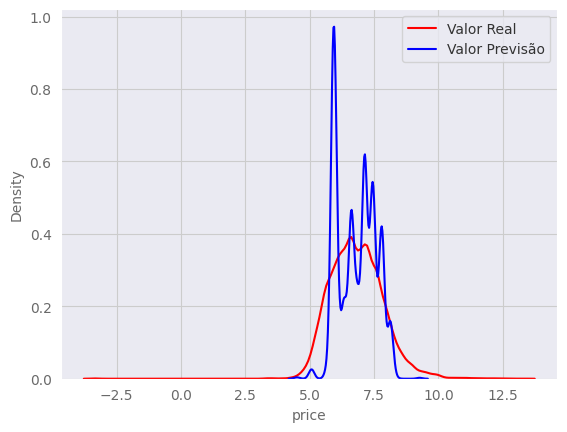

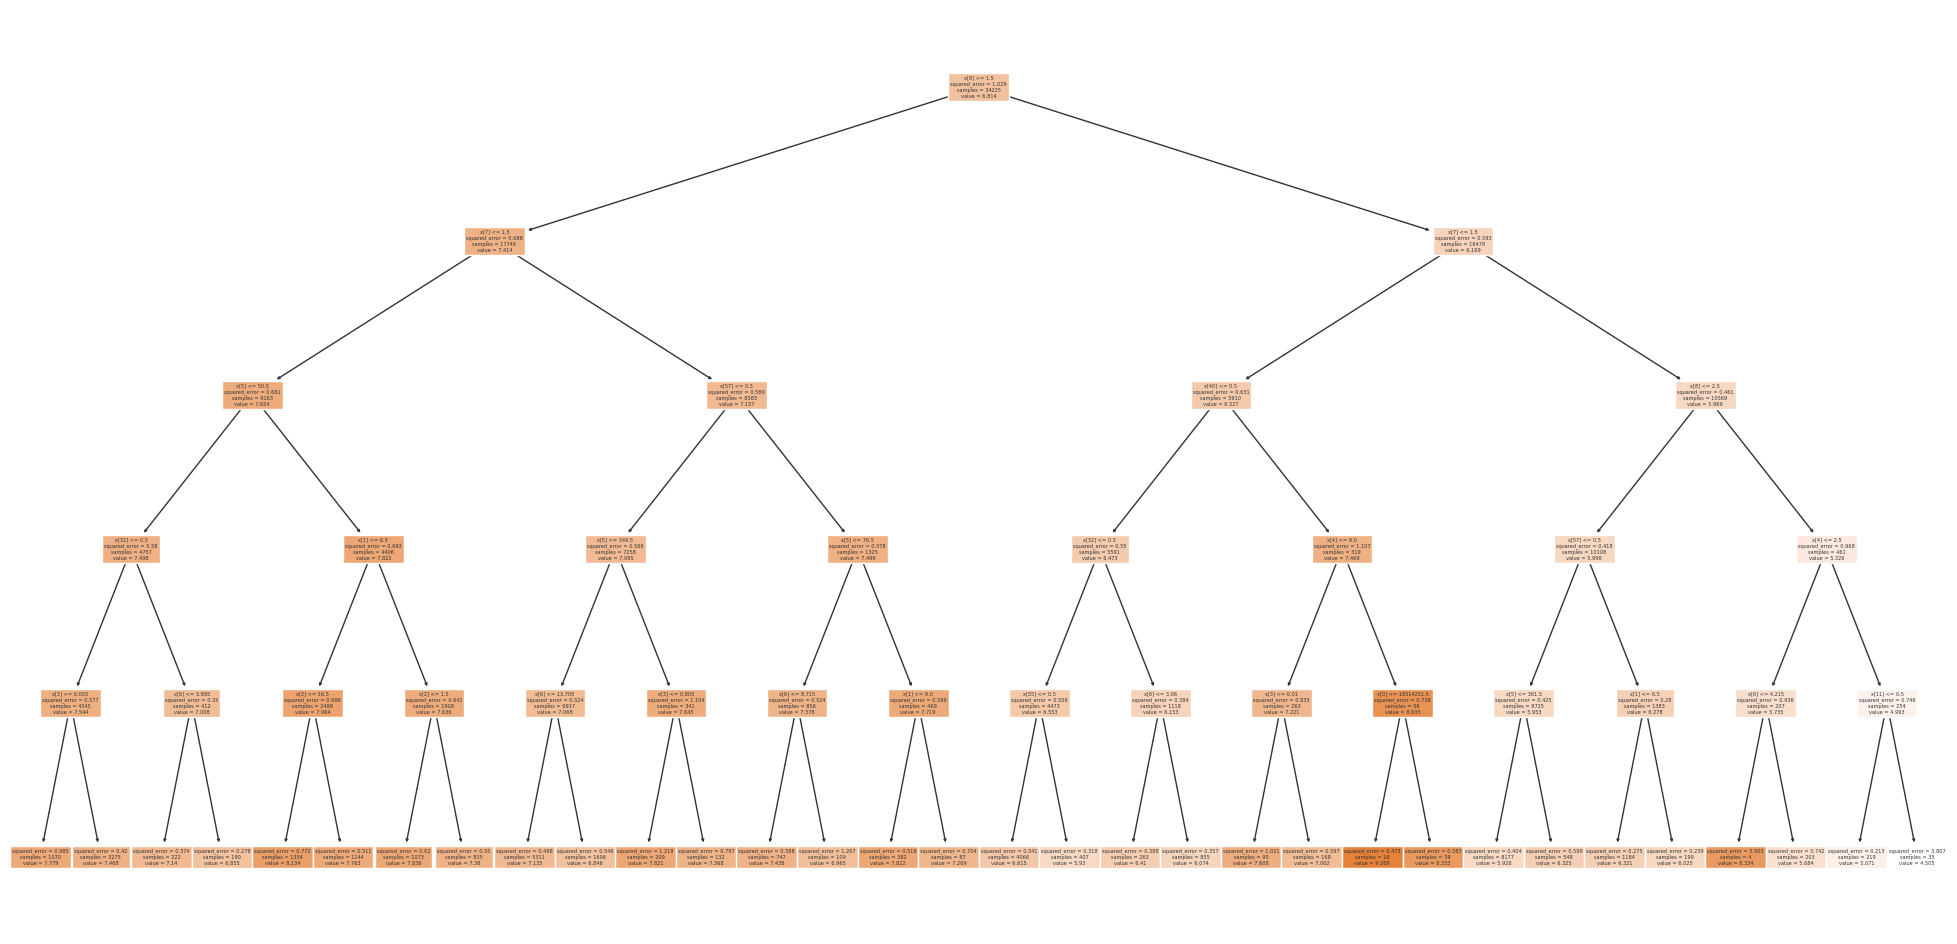

R2:  0.4888429777685316
MAE:  0.5148896405743956
MAPE:  0.07537313982526088
MSE:  0.5370508922751355
RMSE:  0.7328375619979748

Resultados adicionados
Score Treino: 0.5116678626010993

Score Teste: 0.4888429777685316

Função completa aplicada 

Aplicando o Modelo


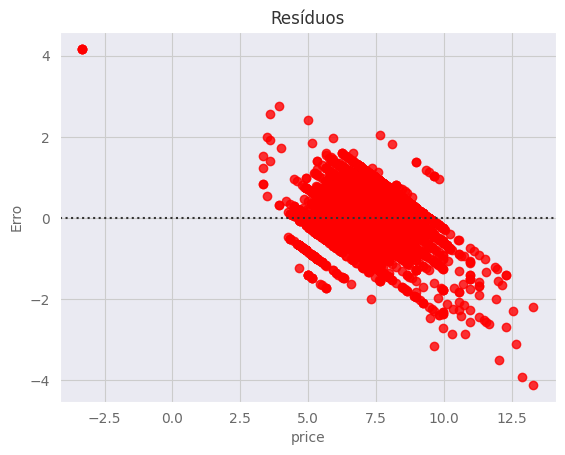

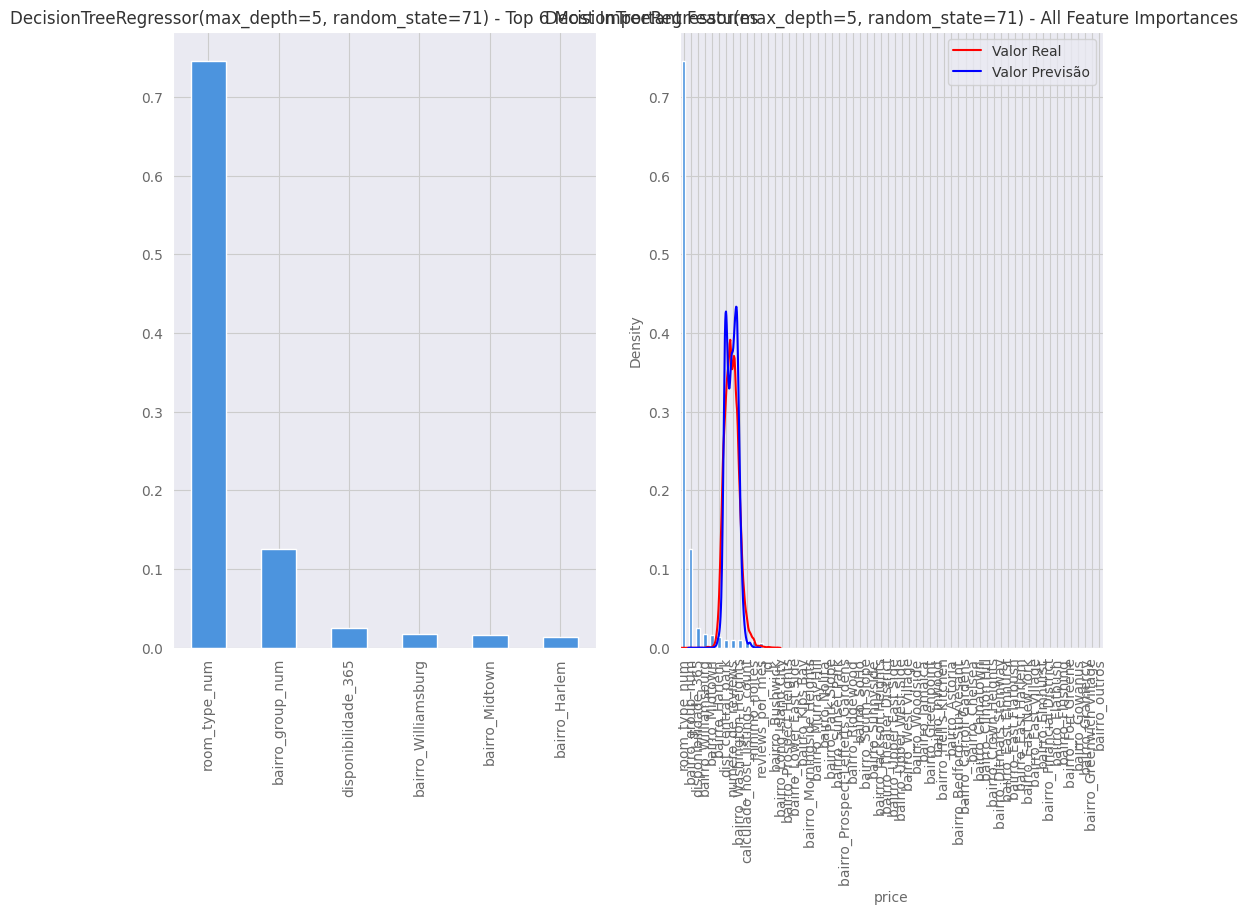

R2:  0.5727934747317767
MAE:  0.4618021757072152
MAPE:  0.06755124915126713
MSE:  0.44884768398460034
RMSE:  0.6699609570598875

Resultados adicionados
Score Treino: 0.9422194663437127

Score Teste: 0.5727934747317767

Função completa aplicada 

Aplicando o Modelo


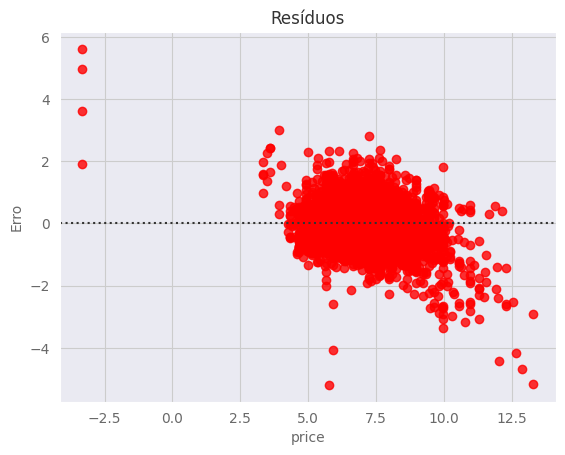

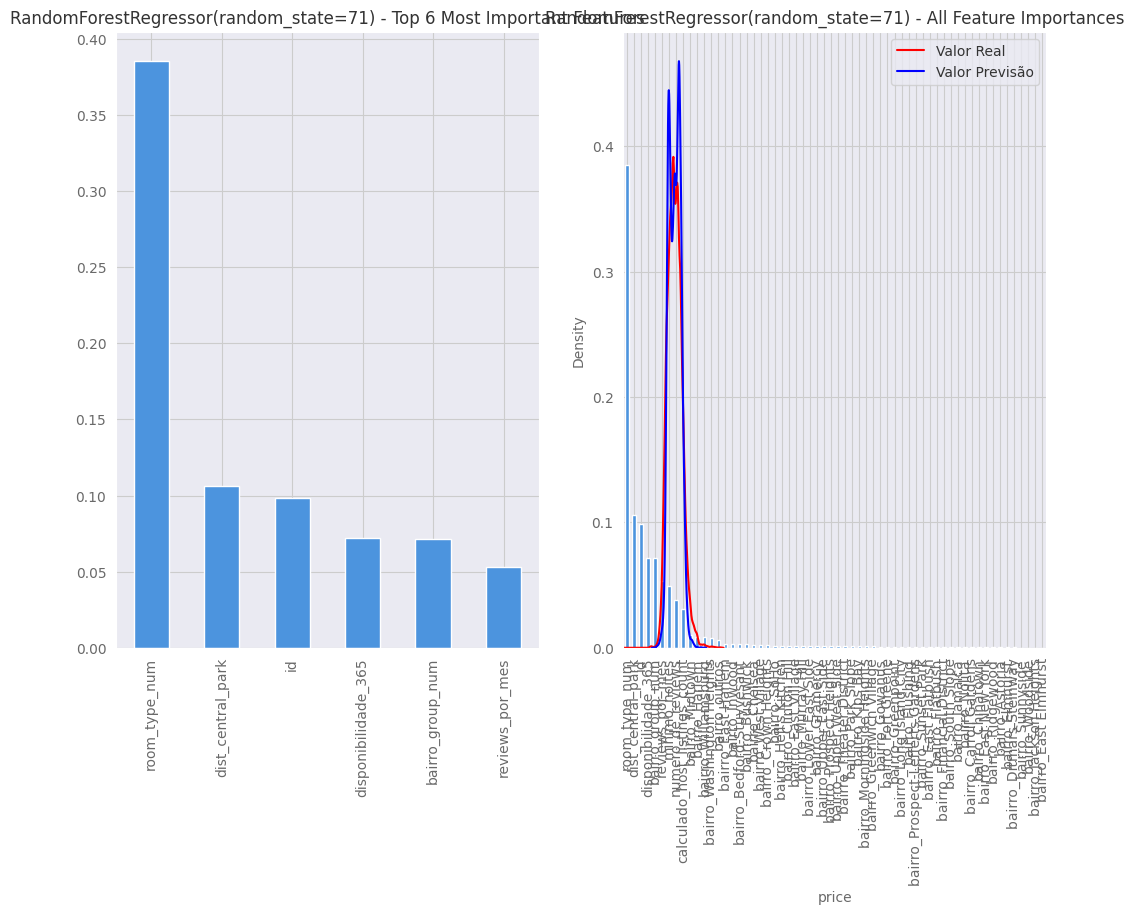

R2:  0.5869511339104847
MAE:  0.4559714837192196
MAPE:  0.06661774220143118
MSE:  0.43397283503650297
RMSE:  0.6587661459398949

Resultados adicionados
Score Treino: 0.7179861648039376

Score Teste: 0.5869511339104847

Função completa aplicada 



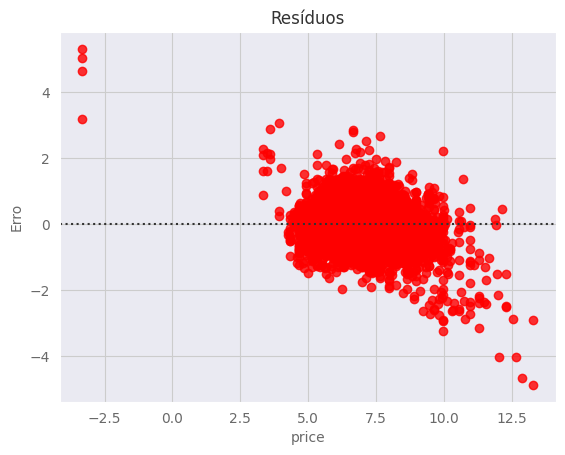

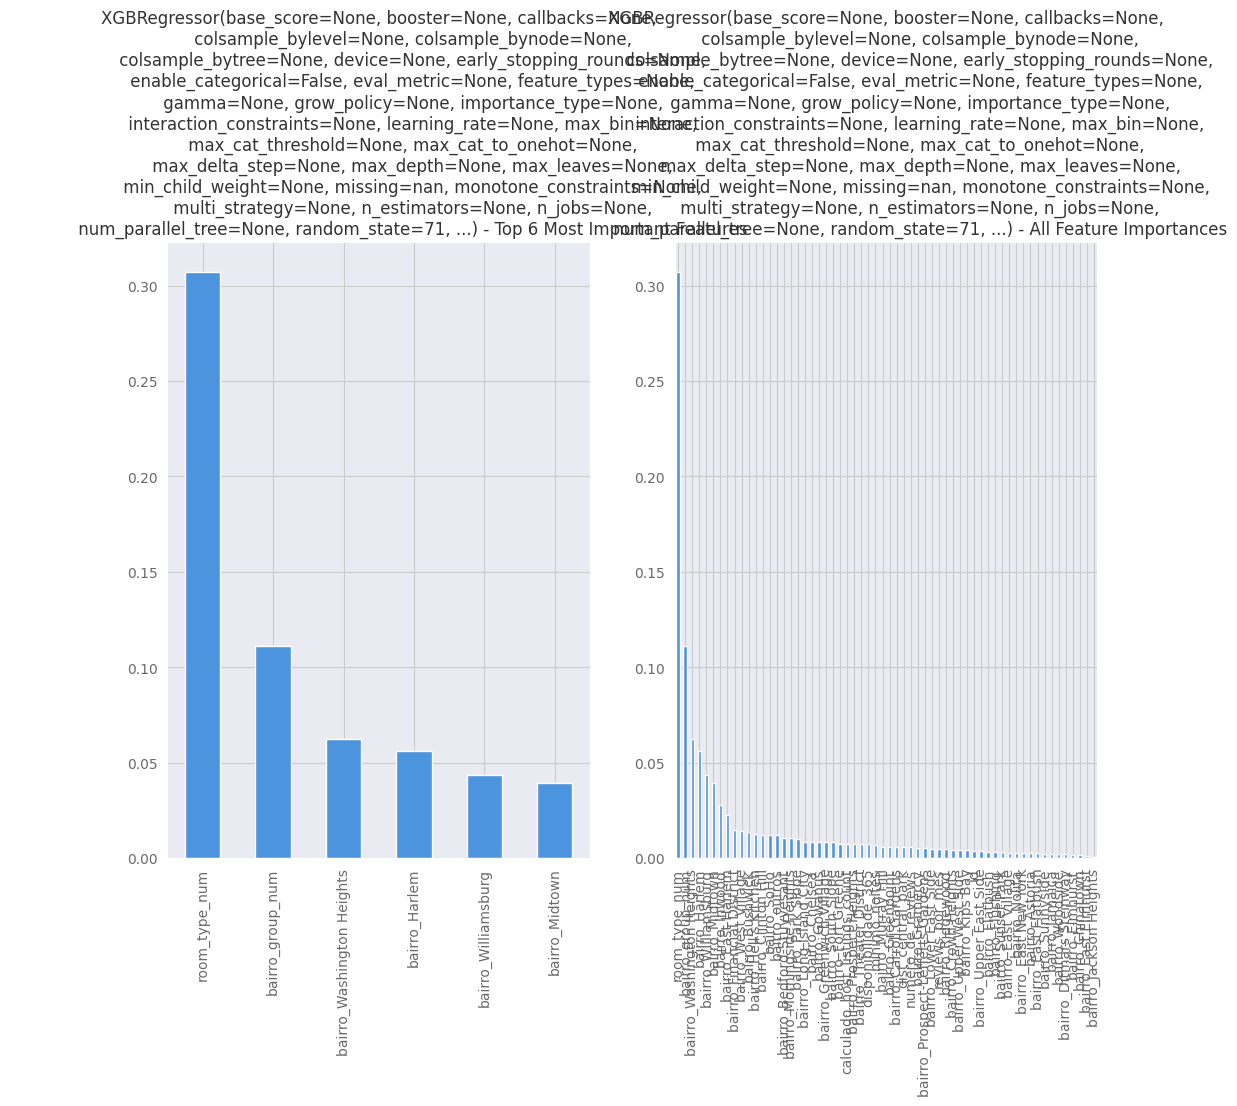

In [ ]:
# First model apply, without Hyperparameters Tunning

for model in models:
  pipeline(model, x_train, x_test, y_train, y_test)


In [ ]:
model_results = pd.DataFrame({'Modelo': model_name,
                              'Score R2': R2,
                              'Mean Abs Error': MAE,
                              'Mean Abs Percent Error': MAPE,
                              'Mean Sqrt Error': MSE,
                              'Residual Mean Sqrt Error': RMSE})

In [ ]:
model_results

Modelo  Score R2  Mean Abs Error  Mean Abs Percent Error  \
0  DecisionTreeRegressor     0.489           0.515                     7.5   
1  RandomForestRegressor     0.573           0.462                     6.8   
2           XGBRegressor     0.587           0.456                     6.7   

   Mean Sqrt Error  Residual Mean Sqrt Error  
0            0.537                     0.733  
1            0.449                     0.670  
2            0.434                     0.659

###Avaliação do Primeiro Fit de Cada Modelo

  * Quanto maior o R2 e menor o erro, melhor a previsão

  * O modelo que mais performou foi o XGBoost, ele obteve o melhor R2 e o menor erro. Vou concentrar em uma tunagem deste modelo que é muito eficiente e rápido para ver se ainda conseguimos uma melhora significativa na predição.

## Tunning XGBoost

In [ ]:
# Tunning XGBoost Model

model = xgboost

xgboost_parameter_space = {'learning_rate' : [.001, .01, 1],
                           'max_depth' : [5, 8, 10, 15],
                           'n_estimators' : [30, 40, 50, 60, 70, 80],
                           'gamma' : [0.8, 1, 2, 5, 7, 10],
                           'reg_alpha' : [0, 0.05, 0.1, 1],
                           'reg_lambda' : [0, 0.1, 1, 2, 5]
                           }


# Using bayes search CV to optimize hyperparameters

bayes_search = BayesSearchCV(model, xgboost_parameter_space, cv= 5,
                                 n_iter= 20, verbose= 0, random_state= 71)

bayes_search.fit(x_train, y_train)

print(f"Score Médio Treino: {bayes_search.score(x_train, y_train).mean()}\n")
print(f"Score Médio Teste: {bayes_search.score(x_test, y_test).mean()}\n")

print(f"O melhor parâmetro entre todos para estimar y_predict:\n{bayes_search.best_estimator_}\n")
print(f"O maior Score entre todos os parâmetros testados:\n{bayes_search.best_score_}\n")
print(f"A melhor combinação de parâmetros:\n{bayes_search.best_params_}\n")

Score Médio Treino: 0.6074578439580387

Score Médio Teste: 0.5581612789363639

O melhor parâmetro entre todos para estimar y_predict:
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=2.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=1.0, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=60, n_jobs=None,
             num_parallel_tree=None, random_state=71, ...)

O maior Score entre todos os parâmetros testados:
0.5660114680882583

A melhor combinação de parâmetros:
OrderedDict([('gamma',

Aplicando o Modelo


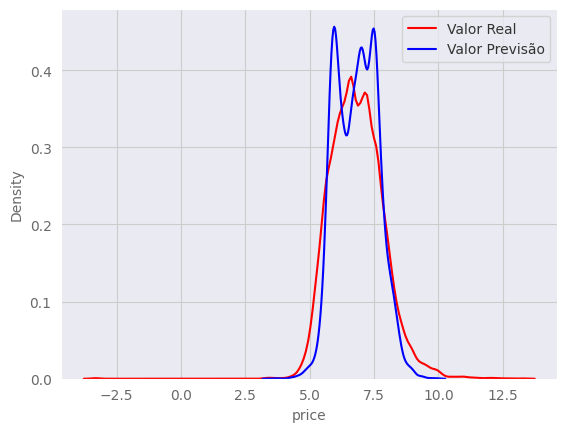

R2:  0.5581612789363639
MAE:  0.4754703821426013
MAPE:  0.0695046643616932
MSE:  0.46422110832603986
RMSE:  0.6813377344063954

Resultados adicionados
Score Treino: 0.6074578439580387

Score Teste: 0.5581612789363639

Função completa aplicada 



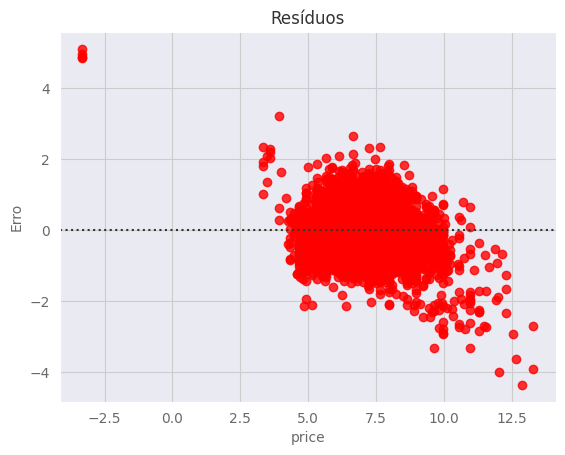

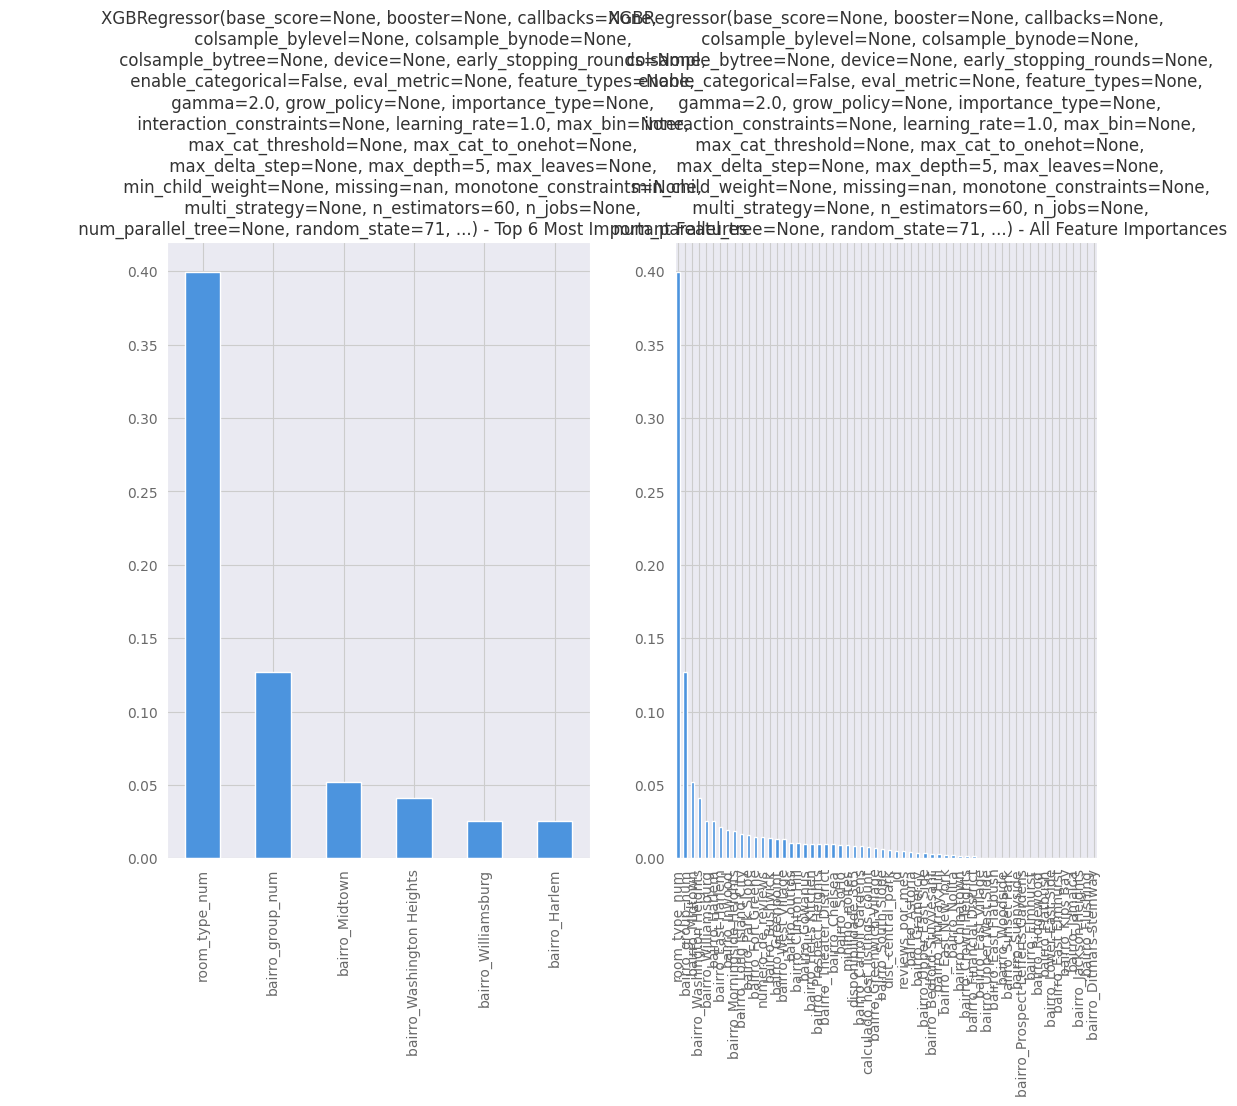

In [ ]:
# Saving a model with the best estimator parameters and trying new pipeline to evaluate optimization results

best_xgboost = bayes_search.best_estimator_

# Trying the pipeline model again

pipeline (best_xgboost, x_train, x_test, y_train, y_test)

In [ ]:
y_predict = model.predict(x_test)


In [ ]:
y_predict

array([8.1471405, 7.867583 , 5.9381146, ..., 6.951027 , 6.811802 ,
       6.5901456], dtype=float32)

In [ ]:
df.loc[df['id'] == 2595]

id                   nome  host_id host_name bairro_group   bairro  \
0  2595  Skylit Midtown Castle     2845  Jennifer    Manhattan  Midtown   

   latitude  longitude        room_type  price  minimo_noites  \
0  40.75362  -73.98377  Entire home/apt    225              1   

   numero_de_reviews ultima_review  reviews_por_mes  \
0                 45    2019-05-21             0.38   

   calculado_host_listings_count  disponibilidade_365  dist_central_park  \
0                              2                  355               3.73   

   bairro_group_num  room_type_num  price_bins  
0                 1              1  (200, 250]

In [ ]:
round(mean_absolute_percentage_error(y_test, y_predict), 3)*100

6.7

### Métricas do Melhor Modelo

  * R2 = 0,557  => Significa que com este modelo explicamos 55% aproximadamente da variabilidade do preço dos imóveis.

  * MAE = 0,32 => É o menor erro médio de todos os modelos testados. Significa que a previsão com este modelo é a que menos desvia da linha de regressão média.

  

# Previsão de Novos Dados

In [ ]:
df_previsao_teste = pd.DataFrame({'id': [2595],
                                  'nome': ['Skylit Midtown Castle'],
                                  'host_id': [2845],
                                  'host_name': ['Jennifer'],
                                  'bairro_group': ['Manhattan'],
                                  'bairro': ['Midtown'],
                                  'latitude': [40.75362],
                                  'longitude': [-73.98377],
                                  'room_type': ['Entire home/apt'],
                                  'price': [225],
                                  'minimo_noites': [1],
                                  'numero_de_reviews': [45],
                                  'ultima_review': ['2019-05-21'],
                                  'reviews_por_mes': [0.38],
                                  'calculado_host_listings_count': [2],
                                  'disponibilidade_365': [355]}).set_index('id')

# This are the new data on wich we want to predict the propertie price
df_previsao_teste

nome  host_id host_name bairro_group   bairro  \
id                                                                     
2595  Skylit Midtown Castle     2845  Jennifer    Manhattan  Midtown   

      latitude  longitude        room_type  price  minimo_noites  \
id                                                                 
2595  40.75362  -73.98377  Entire home/apt    225              1   

      numero_de_reviews ultima_review  reviews_por_mes  \
id                                                       
2595                 45    2019-05-21             0.38   

      calculado_host_listings_count  disponibilidade_365  
id                                                        
2595                              2                  355

In [ ]:
# Inserting all neighborhood columns from the one hot encoding

df_one_hot_new = pd.get_dummies(df_previsao_teste, columns=['bairro'])

In [ ]:
df_one_hot_new.drop(columns= ['nome', 'host_id', 'host_name', 'bairro_group', 'latitude',
       'longitude', 'room_type', 'price', 'minimo_noites', 'numero_de_reviews',
       'ultima_review', 'reviews_por_mes', 'calculado_host_listings_count',
       'disponibilidade_365'], inplace= True)

In [ ]:
df_previsao_teste = df_previsao_teste.merge(df_one_hot_new, how= 'left', on= 'id')

In [ ]:
df_previsao_teste

nome  host_id host_name bairro_group   bairro  \
id                                                                     
2595  Skylit Midtown Castle     2845  Jennifer    Manhattan  Midtown   

      latitude  longitude        room_type  price  minimo_noites  \
id                                                                 
2595  40.75362  -73.98377  Entire home/apt    225              1   

      numero_de_reviews ultima_review  reviews_por_mes  \
id                                                       
2595                 45    2019-05-21             0.38   

      calculado_host_listings_count  disponibilidade_365  bairro_Midtown  
id                                                                        
2595                              2                  355               1

In [ ]:
# Listing all columns in training set

bairros_columns = ['id','bairro_Astoria', 'bairro_Bedford-Stuyvesant', 'bairro_Bushwick',
       'bairro_Carroll Gardens', 'bairro_Chelsea', 'bairro_Chinatown',
       'bairro_Clinton Hill', 'bairro_Crown Heights',
       'bairro_Ditmars Steinway', 'bairro_East Elmhurst',
       'bairro_East Flatbush', 'bairro_East Harlem', 'bairro_East New York',
       'bairro_East Village', 'bairro_Elmhurst', 'bairro_Financial District',
       'bairro_Flatbush', 'bairro_Flushing', 'bairro_Fort Greene',
       'bairro_Gowanus', 'bairro_Gramercy', 'bairro_Greenpoint',
       'bairro_Greenwich Village', 'bairro_Harlem', "bairro_Hell's Kitchen",
       'bairro_Inwood', 'bairro_Jackson Heights', 'bairro_Jamaica',
       'bairro_Kips Bay', 'bairro_Long Island City', 'bairro_Lower East Side',
       'bairro_Midtown', 'bairro_Morningside Heights', 'bairro_Murray Hill',
       'bairro_Nolita', 'bairro_Park Slope', 'bairro_Prospect Heights',
       'bairro_Prospect-Lefferts Gardens', 'bairro_Ridgewood', 'bairro_SoHo',
       'bairro_South Slope', 'bairro_Sunnyside', 'bairro_Sunset Park',
       'bairro_Theater District', 'bairro_Upper East Side',
       'bairro_Upper West Side', 'bairro_Washington Heights',
       'bairro_West Village', 'bairro_Williamsburg', 'bairro_Woodside',
       'bairro_outros']

In [ ]:
# Loop for all columns and include them on dataset

for col in bairros_columns:
  if col not in df_previsao_teste:
    df_previsao_teste[col] = 0
  else:
    pass



In [ ]:
df_previsao_teste.columns

Index(['nome', 'host_id', 'host_name', 'bairro_group', 'bairro', 'latitude',
       'longitude', 'room_type', 'price', 'minimo_noites', 'numero_de_reviews',
       'ultima_review', 'reviews_por_mes', 'calculado_host_listings_count',
       'disponibilidade_365', 'bairro_Midtown', 'id', 'bairro_Astoria',
       'bairro_Bedford-Stuyvesant', 'bairro_Bushwick',
       'bairro_Carroll Gardens', 'bairro_Chelsea', 'bairro_Chinatown',
       'bairro_Clinton Hill', 'bairro_Crown Heights',
       'bairro_Ditmars Steinway', 'bairro_East Elmhurst',
       'bairro_East Flatbush', 'bairro_East Harlem', 'bairro_East New York',
       'bairro_East Village', 'bairro_Elmhurst', 'bairro_Financial District',
       'bairro_Flatbush', 'bairro_Flushing', 'bairro_Fort Greene',
       'bairro_Gowanus', 'bairro_Gramercy', 'bairro_Greenpoint',
       'bairro_Greenwich Village', 'bairro_Harlem', 'bairro_Hell's Kitchen',
       'bairro_Inwood', 'bairro_Jackson Heights', 'bairro_Jamaica',
       'bairro_Kips Bay',

In [ ]:
# comparing column names in both x_train and df_previsao_teste dataset

for col in df_previsao_teste.columns:
  if col not in x_train.columns:
    print(col)
  else:
    pass


nome
host_id
host_name
bairro_group
bairro
latitude
longitude
room_type
price
ultima_review


In [ ]:
# Pre processing, clean and feature enginnering steps before applying the selected model

coords = geopy.Point(40.785091, -73.968285)

def dist_central_park(df_new, coords):
  df_new['dist_central_park'] = round(geopy.distance.geodesic(coords, Point(40.753621,	-73.983775)).km, 2)


def bairro_group_num(df_new):
  df_new['bairro_group_num'] = df_new['bairro_group'].apply(lambda x: 1 if x == 'Manhattan'
                                                         else 2 if x == 'Brooklyn'
                                                         else 3 if x == 'Queens'
                                                         else 4 if x == 'Staten Island' else 5).astype('int')

def room_type_num(df_new):
  df_new['room_type_num'] = df_new['room_type'].apply(lambda x: 1 if x == 'Entire home/apt'
                                                   else 2 if x == 'Private room'
                                                   else 3).astype('int')

def date_ultima_review(df_new):
  df_new['ultima_review'] = pd.to_datetime(df_new['ultima_review'], errors= 'coerce')


def drop_columns(df_new):
  df_new.drop(columns= ['nome', 'host_id', 'host_name', 'ultima_review', 'bairro',
                        'bairro_group', 'room_type', 'latitude', 'longitude'], inplace= True)


In [ ]:
# Create a pipeline to pre process new data

def pipe_pre_processing(df_new, coords):
  dist_central_park(df_new, coords)
  bairro_group_num(df_new)
  room_type_num(df_new)
  date_ultima_review(df_new)
  drop_columns(df_new)

  return(df_new)


In [ ]:
# Return log value of price to normal scale

def inverse_log(col):
  predicted_price = np.exp2(col)

  print(predicted_price)


In [ ]:
# applying to new data

pipe_pre_processing(df_previsao_teste, coords)



price  minimo_noites  numero_de_reviews  reviews_por_mes  \
id                                                               
2595    225              1                 45             0.38   

      calculado_host_listings_count  disponibilidade_365  bairro_Midtown  id  \
id                                                                             
2595                              2                  355               1   0   

      bairro_Astoria  bairro_Bedford-Stuyvesant  ...  bairro_Upper East Side  \
id                                               ...                           
2595               0                          0  ...                       0   

      bairro_Upper West Side  bairro_Washington Heights  bairro_West Village  \
id                                                                             
2595                       0                          0                    0   

      bairro_Williamsburg  bairro_Woodside  bairro_outros  dist_central_park  \
id                                                                             
2595                    0                0              0               3.73   

      bairro_group_num  room_type_num  
id                                     
2595                 1              1  

[1 rows x 61 columns]

In [ ]:
# Define x and target

x = df_previsao_teste.drop(columns= ['price'])
y = df_previsao_teste['price']

In [ ]:
# Reorder columns to match training set

x = x[['id', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'calculado_host_listings_count',
       'disponibilidade_365', 'dist_central_park', 'bairro_group_num', 'room_type_num', 'bairro_Astoria',
       'bairro_Bedford-Stuyvesant', 'bairro_Bushwick', 'bairro_Carroll Gardens', 'bairro_Chelsea', 'bairro_Chinatown',
       'bairro_Clinton Hill', 'bairro_Crown Heights', 'bairro_Ditmars Steinway', 'bairro_East Elmhurst', 'bairro_East Flatbush',
       'bairro_East Harlem', 'bairro_East New York', 'bairro_East Village', 'bairro_Elmhurst', 'bairro_Financial District',
       'bairro_Flatbush', 'bairro_Flushing', 'bairro_Fort Greene', 'bairro_Gowanus', 'bairro_Gramercy', 'bairro_Greenpoint',
       'bairro_Greenwich Village', 'bairro_Harlem', "bairro_Hell's Kitchen", 'bairro_Inwood', 'bairro_Jackson Heights',
       'bairro_Jamaica', 'bairro_Kips Bay', 'bairro_Long Island City', 'bairro_Lower East Side', 'bairro_Midtown',
       'bairro_Morningside Heights', 'bairro_Murray Hill', 'bairro_Nolita', 'bairro_Park Slope', 'bairro_Prospect Heights',
       'bairro_Prospect-Lefferts Gardens', 'bairro_Ridgewood', 'bairro_SoHo', 'bairro_South Slope', 'bairro_Sunnyside',
       'bairro_Sunset Park', 'bairro_Theater District', 'bairro_Upper East Side', 'bairro_Upper West Side',
       'bairro_Washington Heights', 'bairro_West Village', 'bairro_Williamsburg', 'bairro_Woodside', 'bairro_outros']]

In [ ]:
# Applying best model

y_pred = best_xgboost.predict(x)
display(y_pred)


array([8.118027], dtype=float32)

In [ ]:
# Changing predicted value in log scale to real scale using the inverse log function

inverse_log(y_pred)

[277.82385]


#Conclusão

  * Após refazer o pipeline de pré processamento e deixar a estrutura do dataset com os dados de previsão iguais ao dataset de treino, rodamos o modelo escolhido (XGBoost) e produzimos um valor predito para o preço do imóvel definido pelo problema.

  * A efetividade da previsão do modelo foi razoável. O preço real do imóvel de ID 2595 é igual a U$ 225 e o preço predito foi Us 277,8, perfazendo um erro de  Us 52,8 ou aprox 19,1%.

  * Para melhorar a precisão deste valor, poderíamos utilizar apenas as variáveis mais importantes para o modelo ao invés de usar todas as que foram usadas neste primeiro momento.

  * Seria possível também utilizar novas features através de feature enginnering para tentar aprimorar a capacidade de previsão do modelo.

###Salvando modelo treinado em formato pkl

In [ ]:
import pickle

# Saving to pickle

In [ ]:
with open ('model_xgboost_pickle', 'wb') as d:
  pickle.dump(best_xgboost, d)

#Saving pickle file

In [ ]:
with open ('model_xgboost_pickle', 'rb') as d:
  mp = pickle.load(d)

# Opening saved pickle file to test it

In [ ]:
mp.predict(x)

# Gives the same answer as modelling

array([8.118027], dtype=float32)